# Exploratory Data Analysis - The Manufacturing Process
*by Manish Khurmi*

### what is my aim with EDA? 
- Explore the dataset, understand what might be driving the machine failures.
- forecast when the machine might fail.

In [88]:
# My classes 
from manufacturing_eda_classes import LoadData, DataFrameInfo, DataTransform, Plotter, Models

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

# Table of Contents

1. [The Data Set](#intro)
2. [Remove / impute missing values](#missing-values)
3. [Investigating for Skewness in the data](#skew)
4. [Removing Outliers from the Data](#outliers)
5. [Investigating for Collinearity (Dropping overly correlated columns)](#collinearity)
    1. OLS & VIF 
    2. Chi-Squared Tests
6. [Milestone 4 - Analysis & Evaluation](#analysis)
    1. Logistic Model 


### 1) The Data Set
<a id="intro"></a>

In [90]:
# Load & View The Data
load_data = LoadData('failure_data.csv')  
failure_data_df = load_data.df  # Access the loaded DataFrame
failure_data_df.head(3)

File found: /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv
DataFrame loaded successfully from /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv.


,Unnamed: 0,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,3416,L50595,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0
1,1,7130,L54309,L,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0
2,2,2320,M17179,M,299.2,308.8,1700,33.5,185.0,0,0,0,0,0,0


In [91]:
# Check the column names 
info = DataFrameInfo(failure_data_df)
info.column_names()

Index(['Unnamed: 0', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Machine Failure Data Dictionary

- **UID**: Unique identifier of the machining session
- **product_ID**: Product specific serial number
- **Type**: Quality of the product being created L, M, or H, for low, medium and high quality products
- **air temperature [K]**: Average air temperature in the room during the process in Kelvin
- **process temperature [K]**:  Average air temperature the machine was operating at during production in Kelvin
- **Rotational speed [rpm]**: Average revolutions per minute the tool was operating at
- **Torque [Nm]**: Torque generated by the tool in Newton-meters
- **Tool wear [min]**: The current minutes of wear on the tool in minutes. H, M and L product manufacturing cause 5/3/2 minutes of tool wear. 
- **machine failure**: Label that indicates, whether the machine failed this particular run
- **TWF (tool wear failure)**: Failure in the process due to the tool wearing out
- **head dissipation failure (HDF)**: Lack of heat dissipation caused the process failure
- **power failure (PWF)**: Failure in the process due to lack of power from the tool to complete the process
- **overstrain failure (OSF)**: Failure due to the tool overstraining during the process
- **random failures (RNF)**: Failures in the process which couldn't be categorised

In [92]:
# Is UDI a unique key for the data?
info = DataFrameInfo(failure_data_df)
print(f'UDI is unique to every row of the data: {info.unique_value_count('UDI') == len(failure_data_df)}')

UDI is unique to every row of the data: True


- Drop `Unnamed: 0` is an unwanted index.
- Drop `Product ID` as we have `UDI`

In [93]:
# Drop columns if they exist 
dt = DataTransform(failure_data_df)
failure_data_df = dt.drop_column(vars=['Unnamed: 0', 'Product ID'])

failure_data_df.head(3)

Column List: 
 Index(['Unnamed: 0', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Column List After dropping df
: Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,3416,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0
1,7130,L,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0
2,2320,M,299.2,308.8,1700,33.5,185.0,0,0,0,0,0,0


In [94]:
# First Row at a glance
info = DataFrameInfo(failure_data_df)
# First row
info.return_first_row()

UDI                         3416
Type                           L
Air temperature [K]        301.4
Process temperature [K]    310.4
Rotational speed [rpm]      1579
Torque [Nm]                 36.9
Tool wear [min]            133.0
Machine failure                0
TWF                            0
HDF                            0
PWF                            0
OSF                            0
RNF                            0
Name: 0, dtype: object

In [95]:
# Initial information about the data 
print(f'The shape of the data is: {info.return_shape()}')

print('\n')
print(f'Initial information about the columns of the data: ')
print(info.return_info())

# transform.return_info()

The shape of the data is: (10000, 13)


Initial information about the columns of the data: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      9162 non-null   float64
 3   Process temperature [K]  9119 non-null   float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          9516 non-null   float64
 7   Machine failure          10000 non-null  int64  
 8   TWF                      10000 non-null  int64  
 9   HDF                      10000 non-null  int64  
 10  PWF                      10000 non-null  int64  
 11  OSF                      10000 non-null  int64  
 12  RNF                      10000 non-null

In [96]:
# Categoric variables 
categorical_vars = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF','RNF']
print(f'Categorical variables: {categorical_vars}')

Categorical variables: ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


Change the `Dtype` label in the DataFrame to categorical for the above variables

In [97]:
print(f'`Type` contains the following unique variables: {failure_data_df['Type'].unique()}')

`Type` contains the following unique variables: ['L' 'M' 'H']


Convert `Type` to dummy variables.
- Motivation: handling categorical data to be used in statistical models e.g. Logit Model or Machine Learning Models.

In [98]:
dt = DataTransform(failure_data_df)
type_dummy_df = dt.create_dummies_from_column('Type')
failure_data_df = dt.concat_dataframes(type_dummy_df)

info = DataFrameInfo(failure_data_df)
print(f"\nColumns After concatination: \n{info.column_names()}")


Columns After concatination: 
Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M'],
      dtype='object')


### 2) Remove / impute missing values 
<a id="missing-values"></a>

In [99]:
info = DataFrameInfo(failure_data_df)

percentage_of_null = info.percentage_of_null() 
bool_only_columns_with_missing_values = info.percentage_of_null() > 0 

print('Filter for vars with missing data')
print('Percentage of Missing Data(%): ')

percentage_of_null[bool_only_columns_with_missing_values]

Filter for vars with missing data
Percentage of Missing Data(%): 


Air temperature [K]        8.38
Process temperature [K]    8.81
Tool wear [min]            4.84
dtype: float64

Consider imputation for all 3 variables.

reasoning:
- Tool wear [min] is likely to be a critical variable for `Machine failure`, despite only 4% NULL values, consider imputation rather than dropping the data.
- Air temperature [K] & Process temperature [K] have moderate amount of `NULL` vallues. Consider imputation to prevent minimal loss of relevant data.


#### Air Temperature: imputing missing values 

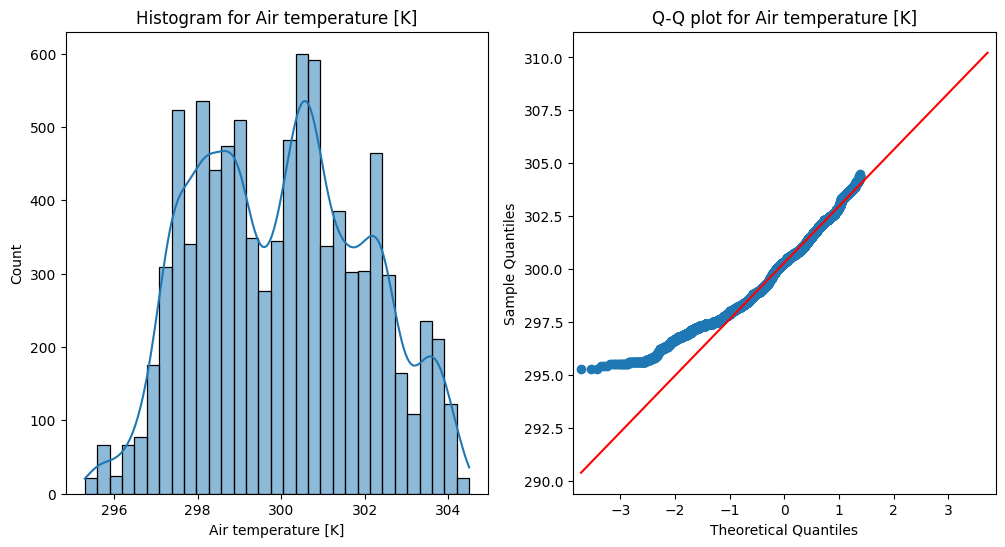

In [100]:
# Histogram & QQ plot for `Air Temperature [K]`
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

plott = Plotter(failure_data_df)
plott.histplot('Air temperature [K]', kde = True, ax = axes[0])
plott.plot_qq('Air temperature [K]', ax=axes[1])

# Display the plots
plt.show()

- Histogram shows a slight negative skew, with a peak to the right of half of the data.
- QQ plot shows deviations from the lower bounds of the `Air temperature [K]`.


In [101]:
info = DataFrameInfo(failure_data_df)
info.normal_test('Air temperature [K]')

Statistics=928.181, p=0.000


The normality test for `Air temperature [K]` 
- p-value < 0.05
- data is symmetrical and follows a normal distribution 

Therefore impute `NULL` values using the **median**. The median is chosen as there is a slight visibly negative skew from the histogram. 
- If the histogram was  symmetrical then we would have chosen the mean to impute.


In [102]:
# Impute NULL values of Air temperature 
dt = DataTransform(failure_data_df)
imputation_dict = {'Air temperature [K]': 'median'}
failure_data_df= dt.impute_missing_values(imputation_dict)


Executing: Imputing Missing Values
Number of NULL values in Air temperature [K] before imputation: 838
Number of NULL values in Air temperature [K] after imputation: 0
Completed: Imputation of Missing Values


#### Process temperature [K]: imputing missing values 

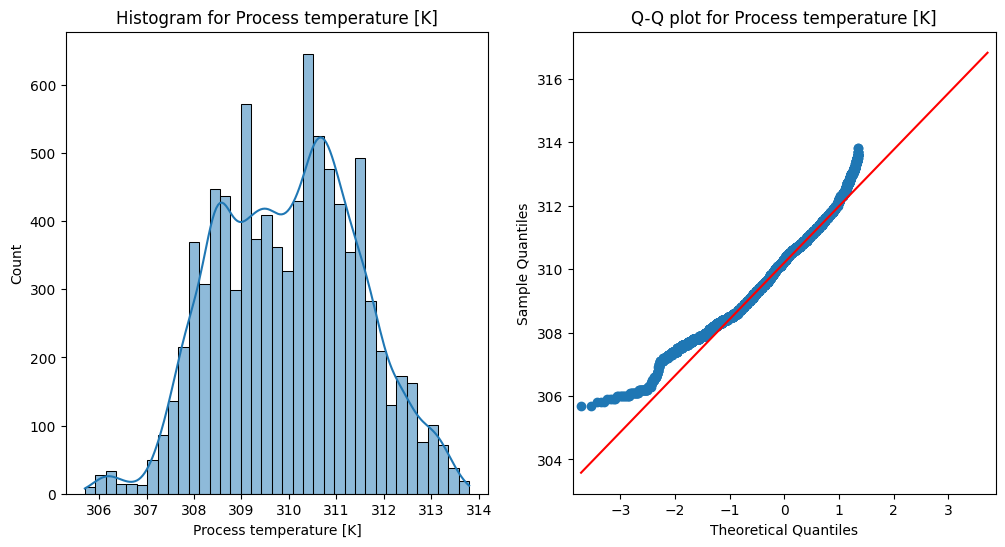

In [103]:
# Histogram & QQ plot for `Process temperature`

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

plott = Plotter(failure_data_df)
plott.histplot('Process temperature [K]', kde = True, ax = axes[0])
plott.plot_qq('Process temperature [K]', ax=axes[1])

# Display the plots
plt.show()

- `Process temperature [K]` Histogram shows a normal distibution, with a peak around 310.9 K 
- Q-Q plot shows significant deviation in the lower bound of the data
- See if the normal test matches the behaviour observed in the Histogram


In [104]:
info = DataFrameInfo(failure_data_df)
info.normal_test('Process temperature [K]')

Statistics=181.218, p=0.000


- normal test has shown a p-value < 0.05, which means we can reject the null hypothesis. 
- `Process temperature [K]` is normally distributed, the data is symmetric

Conclusion: impute using the mean of the data.

In [105]:
# Impute NULL values of `Process temperature [K]` using the median
dt = DataTransform(failure_data_df)
imputation_dict = {'Process temperature [K]': 'mean'}
failure_data_df= dt.impute_missing_values(imputation_dict)


Executing: Imputing Missing Values
Number of NULL values in Process temperature [K] before imputation: 881
Number of NULL values in Process temperature [K] after imputation: 0
Completed: Imputation of Missing Values


#### Tool wear [min]: imputing missing values 

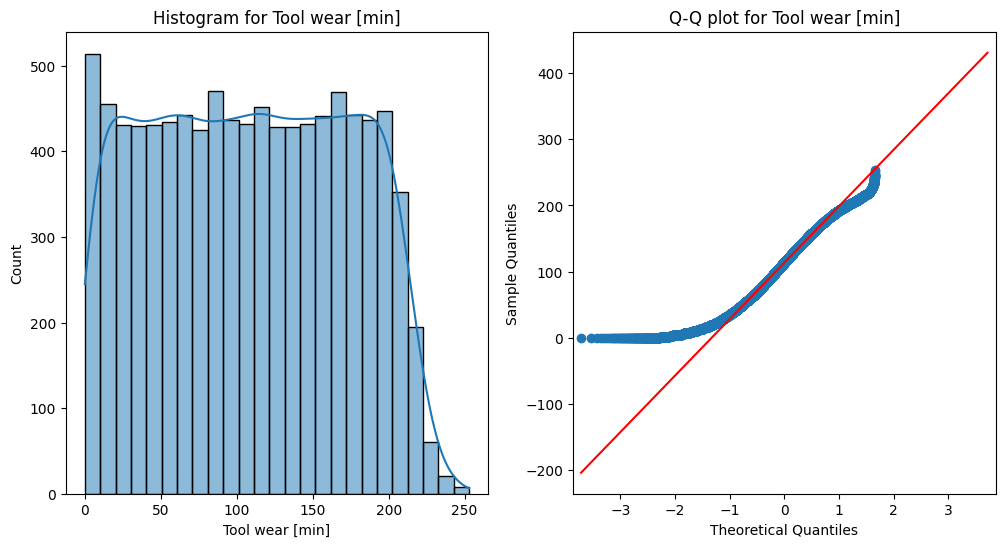

In [106]:
# Histogram & QQ plot for `Process temperature`

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

plott = Plotter(failure_data_df)
plott.histplot('Tool wear [min]', kde = True, ax = axes[0])
plott.plot_qq('Tool wear [min]', ax=axes[1])

# Display the plots
plt.show()

Histogram:
- Positively skewed.
- The Histogram shows consistent spikers throughout the data , these spikes may be due to the 'High" quality tool type lasting longer than the other types.

Q-Q plot 
- significant deviations in the lower quartile. 
- The middle and upper quartile seem to show tendency towards being normally distributed, however, this is rather misleading after viewing the histogram

See if the normal test supports the above 

In [107]:
info = DataFrameInfo(failure_data_df)
info.normal_test('Tool wear [min]')

Statistics=6306.896, p=0.000


Normal Test
- The p-value of the normal test is showing 0, however we know visually that this is not the case from the Histogram of `Tool wear [min]`

#### Imputing method 
- impute using the median of the data. The median was chosen over the mean given the postive skew observed in the histogram. 
- The outliers present for `Tool wear [min]` > 200 are likely to skew the mean, there for median is a more robust method.


In [108]:
# Impute NULL values of `Tool wear [min]` using the median 
dt = DataTransform(failure_data_df)
imputation_dict = {'Tool wear [min]': 'median'}
failure_data_df= dt.impute_missing_values(imputation_dict)


Executing: Imputing Missing Values
Number of NULL values in Tool wear [min] before imputation: 484
Number of NULL values in Tool wear [min] after imputation: 0
Completed: Imputation of Missing Values


In [109]:
# Prove that the new transformed data contails no missing values 
info_df_without_null = DataFrameInfo(failure_data_df)
info_df_without_null.percentage_of_null()

UDI                        0.0
Type                       0.0
Air temperature [K]        0.0
Process temperature [K]    0.0
Rotational speed [rpm]     0.0
Torque [Nm]                0.0
Tool wear [min]            0.0
Machine failure            0.0
TWF                        0.0
HDF                        0.0
PWF                        0.0
OSF                        0.0
RNF                        0.0
H                          0.0
L                          0.0
M                          0.0
dtype: float64

### 3) Investigating for Skewness in the data 
<a id="skew"></a>

In [110]:
# Checkpoint: All the Data Transform steps we have made so far
print('##############################################################################')
print('Step 0: Load the Data')
load_data = LoadData('failure_data.csv')  # Instantiate the class with your file name
failure_data_df = load_data.df  # Access the loaded DataFrame
print('##############################################################################')
print('Step 1: Initial Data Cleaning')
dt = DataTransform(failure_data_df)
failure_data_df = dt.drop_column(['Unnamed: 0', 'Product ID'])

dt = DataTransform(failure_data_df)
type_dummy_df = dt.create_dummies_from_column('Type')
failure_data_df = dt.concat_dataframes(type_dummy_df)

info = DataFrameInfo(failure_data_df)
print(f"\nColumns After concatination: \n{info.column_names()}")
print('##############################################################################')
print('Step 2: Impute missing values')
imputation_dict = {
    'Air temperature [K]': 'median',
    'Process temperature [K]': 'mean',
    'Tool wear [min]': 'median'
}
dt = DataTransform(failure_data_df)
failure_data_df = dt.impute_missing_values(imputation_dict)
info = DataFrameInfo(failure_data_df)
print(f"\nCheck\nPercentage of Null Values for each column after imputation: \n{info.percentage_of_null()}")

##############################################################################
Step 0: Load the Data
File found: /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv
DataFrame loaded successfully from /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv.
##############################################################################
Step 1: Initial Data Cleaning
Column List: 
 Index(['Unnamed: 0', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Column List After dropping df
: Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

Columns After concatination: 
Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K

#### Interpreting the skew() values

- -0.5 < skew_value < 0.5, the data are fairly symmetrical
- If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed


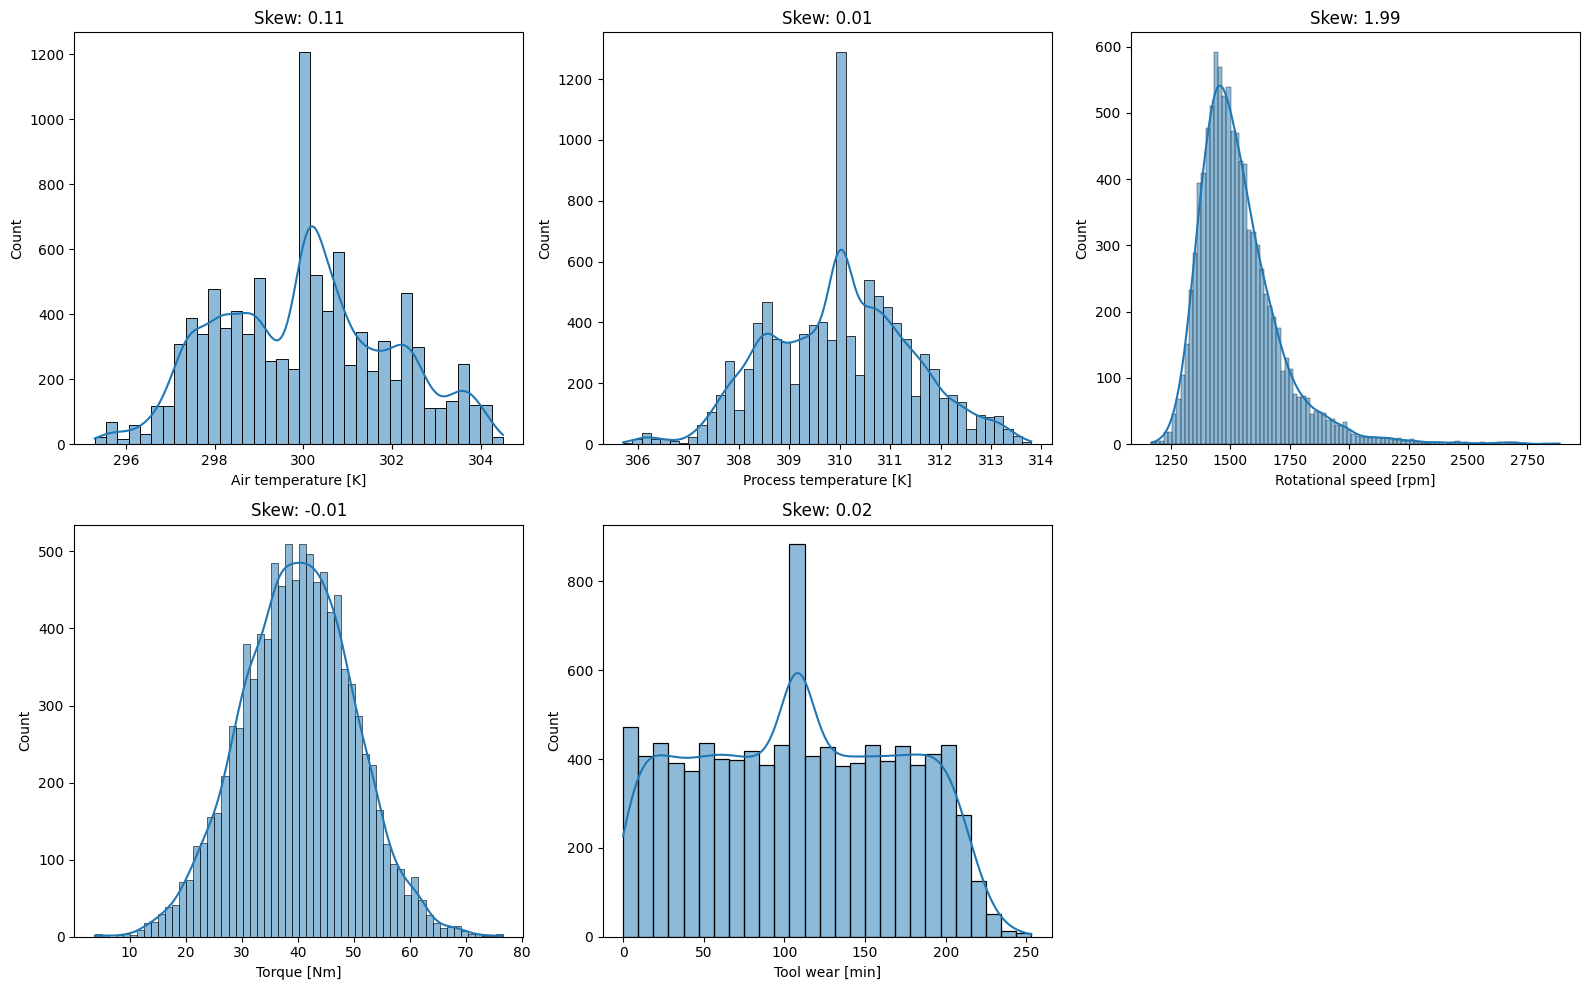

In [111]:
# Initialize the DataInfo class
info = DataFrameInfo(failure_data_df)

# Initialize the Plotter class with the DataFrame and DataInfo object
plott = Plotter(failure_data_df)

# Define continuous variables
continuous_variables = [
    'Air temperature [K]', 
    'Process temperature [K]',
    'Rotational speed [rpm]', 
    'Torque [Nm]', 
    'Tool wear [min]'
]

# Call the method to plot continuous variables
plott.histogram_and_skew_sub_plots(variable_list=continuous_variables, num_cols=3)


Histogram & Skewness Test
- `Rotational speed [rpm]` has a strong positive skew as the skew_value > 1. 
- All other continous data have fairly symmetric data. Treating for skewness will not be considered, as the loss of interpretability outways the gain of symmetry for the model.

In [112]:
print('Step 3: Treating Skewness')
dt = DataTransform(failure_data_df)
info = DataFrameInfo(failure_data_df)
print(f"\nSkew Test Before treatement: {info.skew_test('Rotational speed [rpm]')}")
failure_data_df = dt.treat_skewness(column_name='Rotational speed [rpm]', normalied_column_name='rotational_speed_normalised', method='yeojohnson') # 
info = DataFrameInfo(failure_data_df)
print(f"\nSkew Test After treatement: {info.skew_test('rotational_speed_normalised')}")

Step 3: Treating Skewness

Skew Test Before treatement: 1.993171004713752
Applying Yeo-Johnson transform to Rotational speed [rpm]
yeojohnson applied to Rotational speed [rpm].

Skew Test After treatement: 0.0


Histograms of `Rotational Speed [rpm]` Before vs After Treating for Skewness


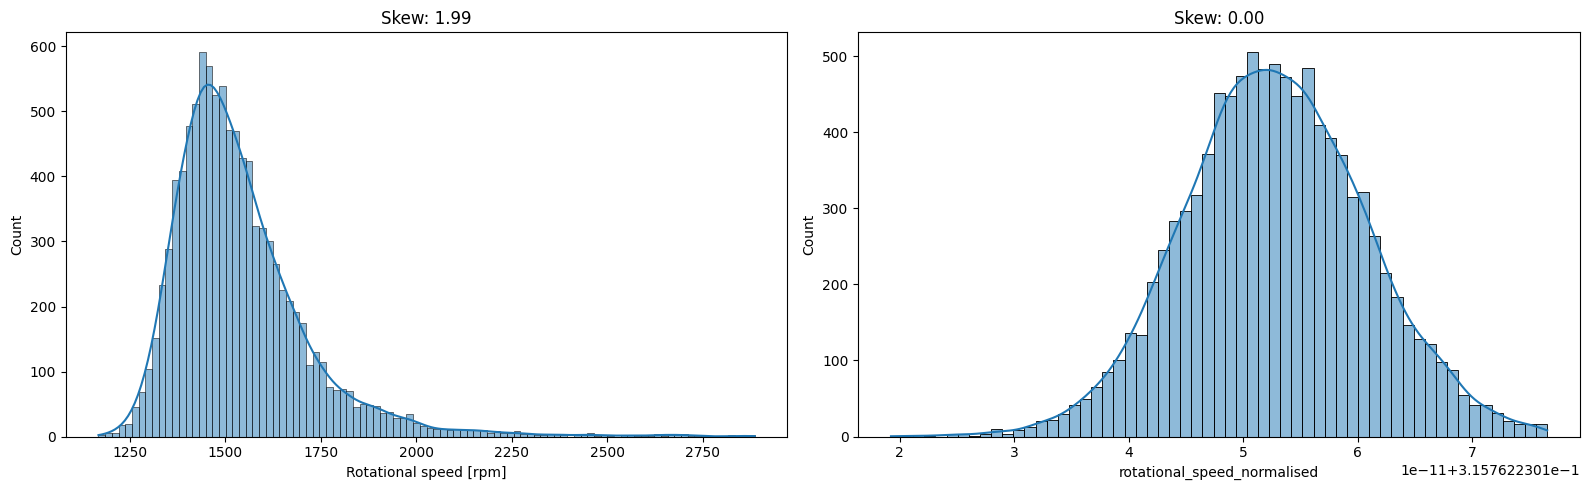

In [113]:
# Compare Histograms of `Rotational Speed [rpm]` Before vs After Treating for Skewness
info = DataFrameInfo(failure_data_df)
dt = DataTransform(failure_data_df)
plott = Plotter(failure_data_df)

# plott.histplot('rotational_speed_normalised')
print('Histograms of `Rotational Speed [rpm]` Before vs After Treating for Skewness')
plott.histogram_and_skew_sub_plots(variable_list=['Rotational speed [rpm]', 'rotational_speed_normalised'], num_cols = 2)

- yeojohnson data transform has for `Rotational speed [rpm]` has been successful. 
- The skew_value is 0, indicating the data is symmetrical after the transformation

### 4) Removing Outliers from the Data 
<a id="outliers"></a>

In [114]:
# Apply steps up to and including treating for skewness 
    # Step 3: Treating for skewness in `Rotational Speed [rpm]`
print('##############################################################################')
print('Step 0: Load the Data')
load_data = LoadData('failure_data.csv')  # Instantiate the class with your file name
failure_data_df = load_data.df  # Access the loaded DataFrame
print('##############################################################################')
print('Step 1: Initial Data Cleaning')
dt = DataTransform(failure_data_df)
failure_data_df = dt.drop_column(['Unnamed: 0', 'Product ID'])

dt = DataTransform(failure_data_df)
type_dummy_df = dt.create_dummies_from_column('Type')
failure_data_df = dt.concat_dataframes(type_dummy_df)

info = DataFrameInfo(failure_data_df)
print(f"\nColumns After concatination: \n{info.column_names()}")
print('##############################################################################')
print('Step 2: Impute missing values')
imputation_dict = {
    'Air temperature [K]': 'median',
    'Process temperature [K]': 'mean',
    'Tool wear [min]': 'median'
}
dt = DataTransform(failure_data_df)
failure_data_df = dt.impute_missing_values(imputation_dict)
info = DataFrameInfo(failure_data_df)
print(f"\nCheck\nPercentage of Null Values for each column after imputation: \n{info.percentage_of_null()}")
print('##############################################################################')
print('Step 3: Treating Skewness')
dt = DataTransform(failure_data_df)
info = DataFrameInfo(failure_data_df)
print(f"\nSkew Test Before treatement: {info.skew_test('Rotational speed [rpm]')}")
failure_data_df = dt.treat_skewness(column_name='Rotational speed [rpm]', normalied_column_name='rotational_speed_normalised', method='yeojohnson') # 
info = DataFrameInfo(failure_data_df)
print(f"\nSkew Test After treatement: {info.skew_test('rotational_speed_normalised')}")

##############################################################################
Step 0: Load the Data
File found: /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv
DataFrame loaded successfully from /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv.
##############################################################################
Step 1: Initial Data Cleaning
Column List: 
 Index(['Unnamed: 0', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Column List After dropping df
: Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

Columns After concatination: 
Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K

In [115]:
failure_data_df.head(3)

,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,H,L,M,rotational_speed_normalised
0,3416,L,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0,0,1,0,0.315762
1,7130,L,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0,0,1,0,0.315762
2,2320,M,299.2,308.8,1700,33.5,185.0,0,0,0,0,0,0,0,0,1,0.315762


#### What to include in the forefront:
- grid of boxplot of all continous variables
- z-score visual of the histogram, thresholds 2 & 3 with the % of the data that is being taken out as outliers. colour the outliers on the Histogram 
    - Threshold 2 vs Threshold 3. My choice also depends on the amount of data loss.

Other thoughts:
- Z-Score > IQR
    - Z-score filitering for all continous variables apart from `Rotational speed`, here we will use IQR.
    - Filtering outliers via Z-score is the chosen methodology since our continous varibles are normally distributed (see section 3 skew tests for supporting evidience). we will filter via Z-Score. 
    - Depending on the data wither a Z-score Threshold of 2 or 3 is used.
- Grid of boxplots of each continous variable

In [116]:
failure_data_df.columns

Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')

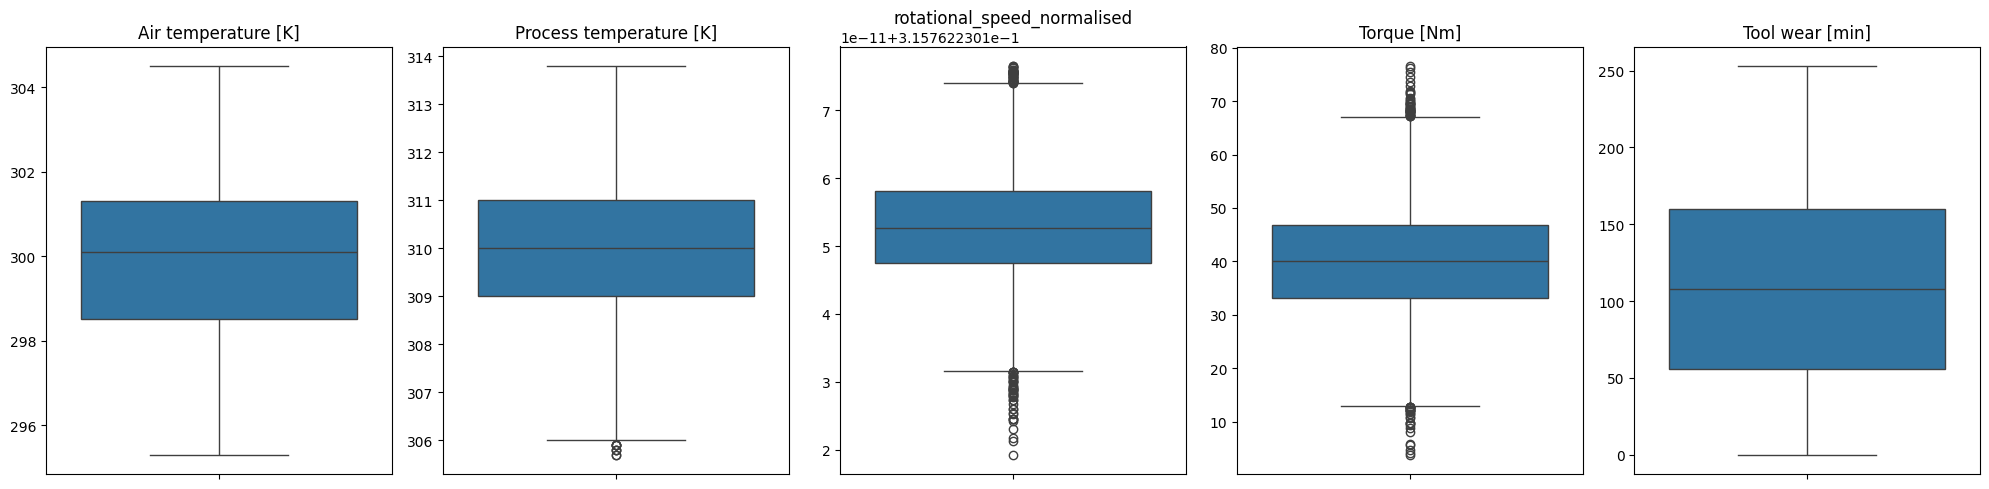

In [117]:
plott = Plotter(failure_data_df)

# List of continuous variables of interest
continous_variables = ['Air temperature [K]', 'Process temperature [K]', 'rotational_speed_normalised', 'Torque [Nm]', 'Tool wear [min]' ]
plott.boxplots(variable_list=continous_variables)

- The Boxplots of `Process temperature [K]`, `Rotational speed [rpm]`, `Torque [Nm]` have outliers and will be investigated further. 
- The Boxplots of `Air temperatures [K]` & `Tool wear [min]` have no outliers in the lower or upper bounds of their data, shown by the absense of observations in the boxplots' whiskers. 

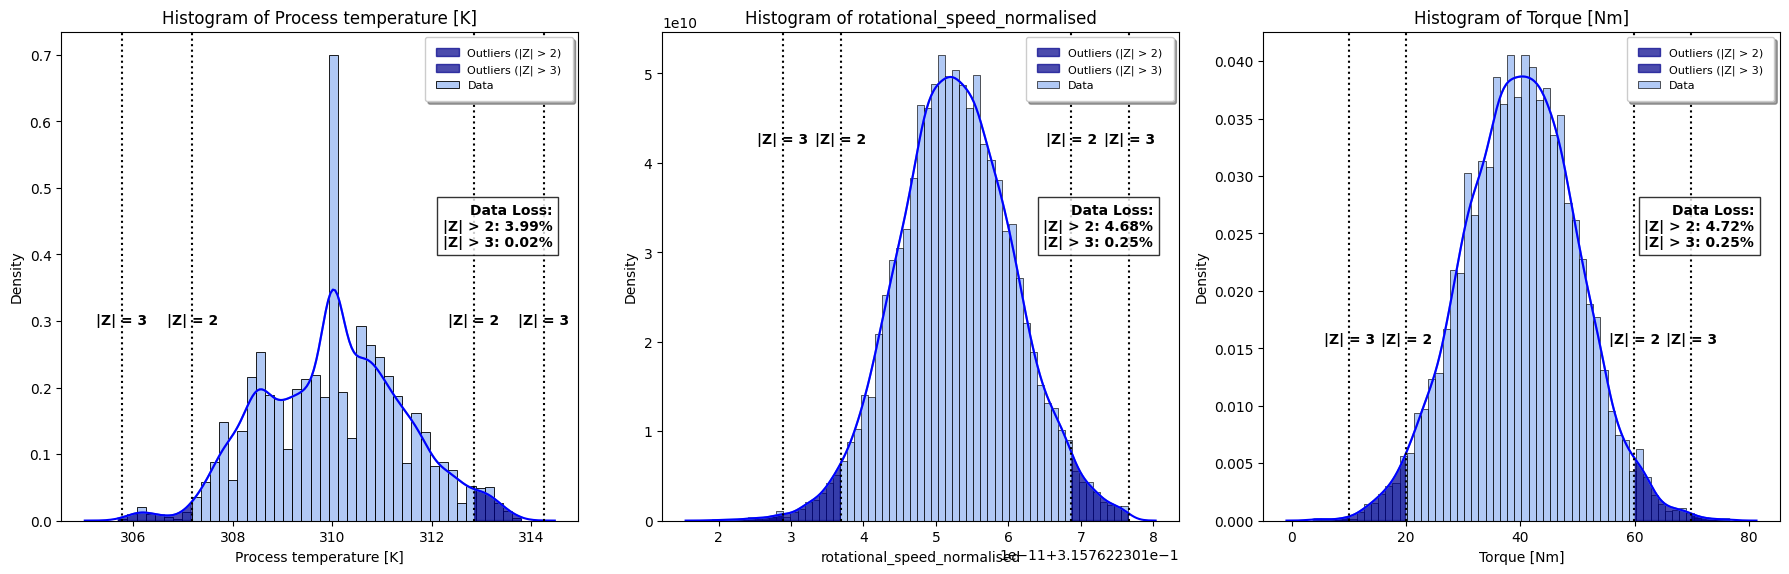

In [118]:
# Create Histograms with Z-score bounds 

plott = Plotter(failure_data_df)
plott.histograms_with_z_score_bounds(vars_list=['Process temperature [K]', 'rotational_speed_normalised', 'Torque [Nm]'])

#### Choosing between a Z-Score Threshold of 2 and 3 
- Given that we dealing with failure data in the manufacturing process, the conseqences of missing a potential failure can be severe. 
- Therefore, consider the more sensitive approach of a threshold of 2.

Pros: more sensitive to deteching smaller anomalies which might be early indicators of potential failures

Cons: Higher number of false positives, meaning more frequent alerts and possibly unnecessary inspections or interventions

Suggested approach (Post implementation):
- Begin with a z-score of 2 i.e. beginning more conservative and increasing based on future data.
- Monitor & Adjust: monitor the alerts and evaluate the relevance of outliers.

# Next Steps:
- Begin with the conservative approach of `|z| > 2`. 
- Make a note here to come back and change z_scores if the model is leading to a loss of productivity for being too conservative.
- ***Strategic EDA decision***: adjust |z| scores.

In [119]:
failure_data_df.columns

Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')

### Box Plots: Before and After Removing Outliers 

In [120]:
# Rename our Data Frame to reflect the before vs after affects of removing outliers
before_removing_outliers_df = failure_data_df

In [121]:
# Remove Outliers 
print('Step 4: Removing Outliers')
outlier_columns = ['rotational_speed_normalised', 'Torque [Nm]', 'Process temperature [K]']
dt = DataTransform(before_removing_outliers_df)
after_removing_outliers_df, _, _ = dt.remove_outliers_with_optimiser(outlier_columns, key_ID='UDI', method='IQR', suppress_output=True)

Step 4: Removing Outliers
Testing combination: ['rotational_speed_normalised', 'Torque [Nm]', 'Process temperature [K]']
Testing combination: ['rotational_speed_normalised', 'Process temperature [K]', 'Torque [Nm]']
Testing combination: ['Torque [Nm]', 'rotational_speed_normalised', 'Process temperature [K]']
Testing combination: ['Torque [Nm]', 'Process temperature [K]', 'rotational_speed_normalised']
Testing combination: ['Process temperature [K]', 'rotational_speed_normalised', 'Torque [Nm]']
Testing combination: ['Process temperature [K]', 'Torque [Nm]', 'rotational_speed_normalised']

Results:
                                         combinations  percentage_data_loss
0  (rotational_speed_normalised, Torque [Nm], Pro...                  1.34
1  (rotational_speed_normalised, Process temperat...                  1.34
2  (Torque [Nm], rotational_speed_normalised, Pro...                  1.41
3  (Torque [Nm], Process temperature [K], rotatio...                  1.41
4  (Process temper

Boxplots Orginal Data:


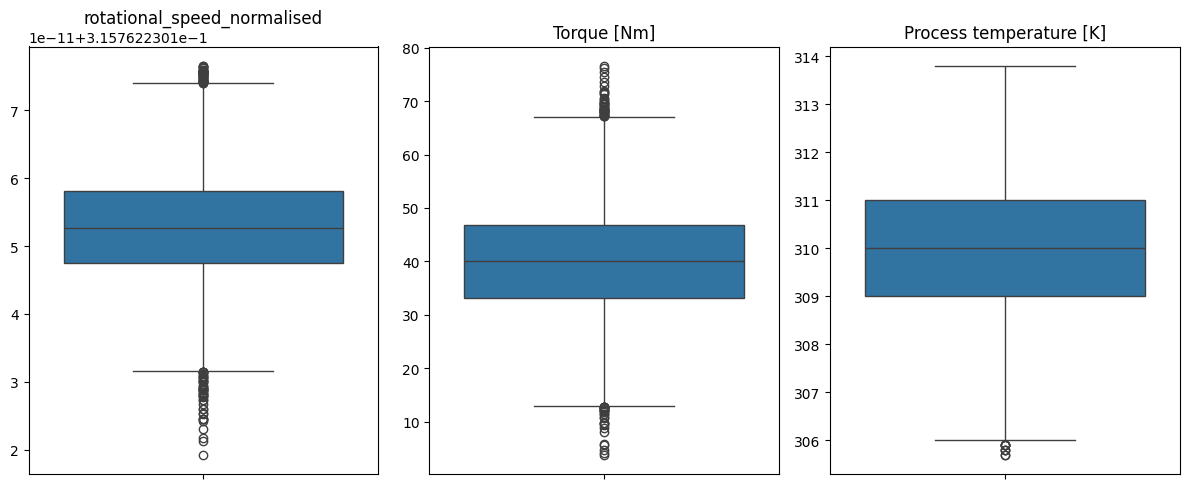

Boxplots After removing Outliers:


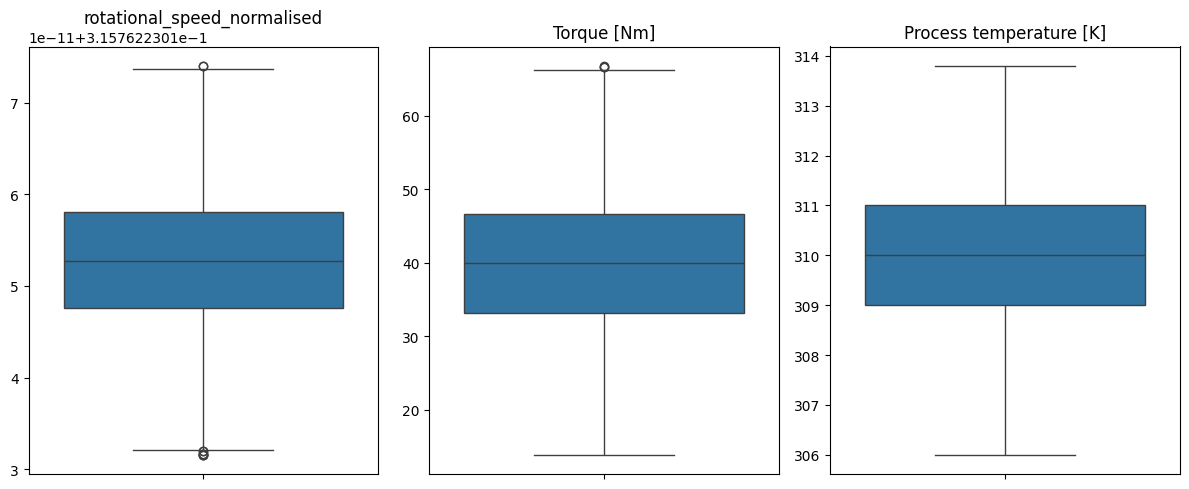


Before Removing outliers:        rotational_speed_normalised   Torque [Nm]  Process temperature [K]
count                 1.000000e+04  10000.000000             10000.000000
mean                  3.157622e-01     39.986910               310.011580
std                   7.970412e-12      9.968934                 1.413428
min                   3.157622e-01      3.800000               305.700000
25%                   3.157622e-01     33.200000               309.000000
50%                   3.157622e-01     40.100000               310.011580
75%                   3.157622e-01     46.800000               311.000000
max                   3.157622e-01     76.600000               313.800000

Before Removing outliers:        rotational_speed_normalised  Torque [Nm]  Process temperature [K]
count                 9.866000e+03  9866.000000              9866.000000
mean                  3.157622e-01    39.908058               310.015316
std                   7.632051e-12     9.570053              

In [122]:
# Comparing Before vs After via Boxplots 

# Initialise Classes: Plotter & DataFrameInfo
plott_before_removing_outliers = Plotter(before_removing_outliers_df)
plott_after_removing_outliers = Plotter(after_removing_outliers_df)

info_before_removing_outliers = DataFrameInfo(before_removing_outliers_df)
info_after_removing_outliers = DataFrameInfo(after_removing_outliers_df)

# Plots & Info Comparison 
print('Boxplots Orginal Data:')
plott_before_removing_outliers.boxplots(outlier_columns)
print('Boxplots After removing Outliers:')
plott_after_removing_outliers.boxplots(outlier_columns)
print(f"\nBefore Removing outliers: {info_before_removing_outliers.describe_statistics(outlier_columns)}")
print(f"\nBefore Removing outliers: {info_after_removing_outliers.describe_statistics(outlier_columns)}")

In [123]:
# Rename the DataFrame 
failure_data_df = after_removing_outliers_df

### 5) Investigating for Collinearity (Dropping overly correlated columns)
<a id="collinearity"></a>

In [124]:
# Checkpoint, All the DataTransformation decision made so far.
print('##############################################################################')
print('Step 0: Load the Data')
load_data = LoadData('failure_data.csv')  # Instantiate the class with your file name
failure_data_df = load_data.df  # Access the loaded DataFrame
print('##############################################################################')
print('Step 1: Initial Data Cleaning')
dt = DataTransform(failure_data_df)
failure_data_df = dt.drop_column(['Unnamed: 0', 'Product ID'])

dt = DataTransform(failure_data_df)
type_dummy_df = dt.create_dummies_from_column('Type')
failure_data_df = dt.concat_dataframes(type_dummy_df)

info = DataFrameInfo(failure_data_df)
print(f"\nColumns After concatination: \n{info.column_names()}")
print('##############################################################################')
print('Step 2: Impute missing values')
imputation_dict = {
    'Air temperature [K]': 'median',
    'Process temperature [K]': 'mean',
    'Tool wear [min]': 'median'
}
dt = DataTransform(failure_data_df)
failure_data_df = dt.impute_missing_values(imputation_dict)
info = DataFrameInfo(failure_data_df)
print(f"\nCheck\nPercentage of Null Values for each column after imputation: \n{info.percentage_of_null()}")
print('##############################################################################')
print('Step 3: Treating Skewness')
dt = DataTransform(failure_data_df)
info = DataFrameInfo(failure_data_df)
print(f"\nSkew Test Before treatement: {info.skew_test('Rotational speed [rpm]')}")
failure_data_df = dt.treat_skewness(column_name='Rotational speed [rpm]', normalied_column_name='rotational_speed_normalised', method='yeojohnson') # 
info = DataFrameInfo(failure_data_df)
print(f"\nSkew Test After treatement: {info.skew_test('rotational_speed_normalised')}")
print('##############################################################################')
print('Step 4: Removing Outliers')
dt = DataTransform(failure_data_df)

info = DataFrameInfo(failure_data_df)
outlier_columns = ['rotational_speed_normalised', 'Torque [Nm]', 'Process temperature [K]']
print(f"\nBefore Removing outliers: {info.describe_statistics(outlier_columns)}")

failure_data_df, _, _ = dt.remove_outliers_with_optimiser(outlier_columns, key_ID='UDI', method='IQR', suppress_output=True)

info = DataFrameInfo(failure_data_df)
print(f"\nAfter Removing outliers: {info.describe_statistics(outlier_columns)}")

##############################################################################
Step 0: Load the Data
File found: /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv
DataFrame loaded successfully from /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv.
##############################################################################
Step 1: Initial Data Cleaning
Column List: 
 Index(['Unnamed: 0', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Column List After dropping df
: Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

Columns After concatination: 
Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K

Summary:

- correlation heatmap 
- filter for abs(correlations) > 0.75 (strong correlations only)
- OLS model & vifs
- chi-squared tests
- logit model 

In [125]:
dt = DataTransform(failure_data_df)
failure_data_df = dt.drop_column(vars=['UDI', 'Type'])

Column List: 
 Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')

Column List After dropping df
: Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M',
       'rotational_speed_normalised'],
      dtype='object')


#### Correlation Heatmap

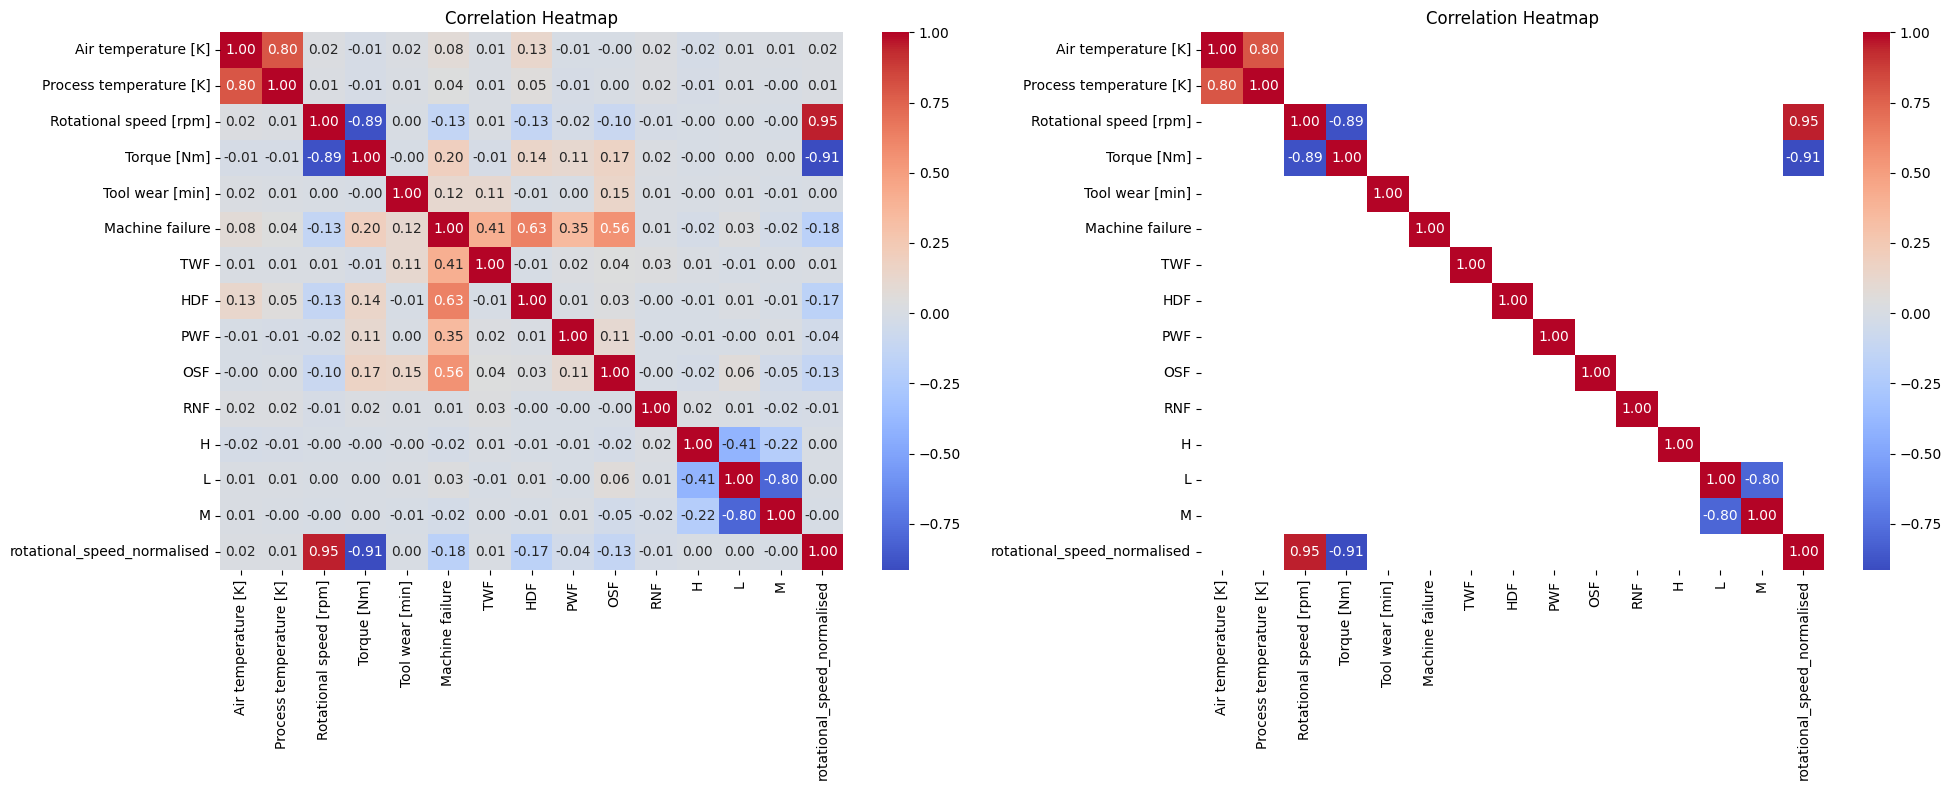

In [126]:
# Initialize the Plotter with DataFrame
plott = Plotter(failure_data_df)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first heatmap on the left subplot (no threshold)
plott.correlation_heatmap(figsize=(10, 8), ax=axes[0])

# Plot the second heatmap with a threshold on the right subplot
plott.correlation_heatmap(threshold=0.75, figsize=(10, 8), ax=axes[1])

# # Adjust layout and show the plots
plt.tight_layout()
plt.show()

#### OLS Model & VIFs

In [127]:
# Rename columns for the OLS model package (no spaces allowed)
dt = DataTransform(failure_data_df)
machine_failure_col_mapping = {
    'Machine failure': 'machine_failure',
    'Air temperature [K]': 'air_temperature',
    'Process temperature [K]': 'process_temperature',
    'Rotational speed [rpm]': 'rotational_speed_actual',
    'Torque [Nm]': 'torque',
    'Tool wear [min]': 'tool_wear'
}

# rename df 
failure_data_df = dt.rename_colunms(machine_failure_col_mapping)

# Save DataFrame
# failure_data_step_5_collinearity.to_csv('failure_data_step_5_collinearity.csv')

# print df 
failure_data_df.head(2)

Before renaming: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M', 'rotational_speed_normalised']

After renaming: ['air_temperature', 'process_temperature', 'rotational_speed_actual', 'torque', 'tool_wear', 'machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M', 'rotational_speed_normalised']



,air_temperature,process_temperature,rotational_speed_actual,torque,tool_wear,machine_failure,TWF,HDF,PWF,OSF,RNF,H,L,M,rotational_speed_normalised
0,301.4,310.4,1579,36.9,133.0,0,0,0,0,0,0,0,1,0,0.315762
1,300.6,310.0,1635,31.0,107.0,0,0,0,0,0,0,0,1,0,0.315762


In [128]:
model = Models(failure_data_df)
model.ols(formula='machine_failure ~ air_temperature + process_temperature + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M', 
          model_summary=1)

                                     Results: Ordinary least squares
Model:                           OLS                          Adj. R-squared:                 0.919      
Dependent Variable:              machine_failure              AIC:                            -32675.9443
Date:                            2024-10-18 15:32             BIC:                            -32582.3852
No. Observations:                9866                         Log-Likelihood:                 16351.     
Df Model:                        12                           F-statistic:                    9374.      
Df Residuals:                    9853                         Prob (F-statistic):             0.00       
R-squared:                       0.919                        Scale:                          0.0021310  
---------------------------------------------------------------------------------------------------------
                                 Coef.         Std.Err.       t     P>|t|       [0.

- These high `p-values` are likely down to the OLS model being a poor choice for modelling dependant variables that are binary. 


In [129]:
model = Models(failure_data_df)

# Exogenous models 
ols_machine_failure = model.ols(formula='machine_failure ~ air_temperature + process_temperature + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')
ols_exog_air_temperature = model.ols(formula='air_temperature ~ machine_failure + process_temperature + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')
ols_exog_process_temperature= model.ols(formula='process_temperature ~ machine_failure + air_temperature + rotational_speed_normalised + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')
ols_exog_torque = model.ols(formula='torque ~ machine_failure + air_temperature + process_temperature + rotational_speed_normalised + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')
ols_exog_rotational_speed = model.ols(formula='rotational_speed_normalised ~ machine_failure + air_temperature + process_temperature + torque + tool_wear + TWF + HDF + PWF + OSF + RNF + H + L + M')

# r2 
print('R²:')
r2_machine_failure = model.r_squared(ols_machine_failure, model_name='machine_failure')
r2_air_temperature = model.r_squared(ols_exog_air_temperature, model_name='air_temperature')
r2_process_temperature = model.r_squared(ols_exog_process_temperature, model_name='air_temperature') 
r2_torque = model.r_squared(ols_exog_torque, model_name='torque')
r2_rotational_speed = model.r_squared(ols_exog_rotational_speed, model_name='rotational_speed' )

# VIFS 
print('\nVIF scores:')
vif_machine_failure = model.VIF(ols_machine_failure, model_name='machine_failure')
vif_air_temperature = model.VIF(ols_exog_air_temperature, model_name='air_temperature')
vif_process_temperature = model.VIF(ols_exog_process_temperature, model_name='process_temperature') 
vif_torque = model.VIF(ols_exog_torque, model_name='torque')
vif_rotational_speed = model.VIF(ols_exog_rotational_speed, model_name='rotational_speed' )    

R²:
machine_failure: 0.9194667158139089
air_temperature: 0.6429909173800379
air_temperature: 0.6374219167653644
torque: 0.8443671051169896
rotational_speed: 0.8425540186824283

VIF scores:
machine_failure: 12.417226120932373
air_temperature: 2.801049185251415
process_temperature: 2.758026605135062
torque: 6.42537685077247
rotational_speed: 6.351384720217024


- All dependant variables have a VIF < 10. Therefore no variable will be dropped.
- Note that using 'rotaional_speed_normlaised' led to higher VIFs than 'rotational_speed_actual.

In [130]:
failure_data_df.columns

Index(['air_temperature', 'process_temperature', 'rotational_speed_actual',
       'torque', 'tool_wear', 'machine_failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF', 'H', 'L', 'M', 'rotational_speed_normalised'],
      dtype='object')

#### Chi-squared tests

In [131]:
model = Models(failure_data_df)
results_df = model.chi_squared_test_df(binary_cols = ['machine_failure','TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'H', 'L', 'M'])

results_df

display('Filter for independant variables which have a statistically insignificant effect on machine_failure:')
display(results_df[(results_df['Variable 1']=='machine_failure') & (results_df['P-Value']>0.05)])

display('Chi-Squared Statistic is > 10 (criteria is based on 1 degree of freedom):')
display(results_df[(results_df['P-Value']>0.05) & (results_df['Chi-Squared Statistic']>=10)])
# tele

'Filter for independant variables which have a statistically insignificant effect on machine_failure:'

,Variable 1,Variable 2,Chi-Squared Statistic,P-Value,Degrees of Freedom
4,machine_failure,RNF,0.000000,1.000000,1
5,machine_failure,H,3.025864,0.081947,1


'Chi-Squared Statistic is > 10 (criteria is based on 1 degree of freedom):'

,Variable 1,Variable 2,Chi-Squared Statistic,P-Value,Degrees of Freedom


Decision: No columns will be dropped based on the Chi-Squared Test.
- `RNF` accounts for the random failures in the process, given the context of the information that this variable holds, it would be beneficial to keep it.
- Further support: although the p-values are not statistically significant for  `RNF` , the Chi-Squared Statistic is still relatively low. 

#### Logistic Model

# Milestone 4 - Analysis & Visualisation 

In [132]:
# print('##############################################################################')
# print('Step 0: Load the Data')
# load_data = LoadData('failure_data.csv')  # Instantiate the class with your file name
# failure_data_df = load_data.df  # Access the loaded DataFrame
# print('##############################################################################')
# print('Step 1: Initial Data Cleaning')
# dt = DataTransform(failure_data_df)
# failure_data_df = dt.drop_column(['Unnamed: 0', 'Product ID'])

# dt = DataTransform(failure_data_df)
# type_dummy_df = dt.create_dummies_from_column('Type')
# failure_data_df = dt.concat_dataframes(type_dummy_df)

# info = DataFrameInfo(failure_data_df)
# print(f"\nColumns After concatination: \n{info.column_names()}")
# print('##############################################################################')
# print('Step 2: Impute missing values')
# imputation_dict = {
#     'Air temperature [K]': 'median',
#     'Process temperature [K]': 'mean',
#     'Tool wear [min]': 'median'
# }
# dt = DataTransform(failure_data_df)
# failure_data_df = dt.impute_missing_values(imputation_dict)
# info = DataFrameInfo(failure_data_df)
# print(f"\nCheck\nPercentage of Null Values for each column after imputation: \n{info.percentage_of_null()}")
# print('##############################################################################')
# print('Step 3: Treating Skewness')
# dt = DataTransform(failure_data_df)
# info = DataFrameInfo(failure_data_df)
# print(f"\nSkew Test Before treatement: {info.skew_test('Rotational speed [rpm]')}")
# failure_data_df = dt.treat_skewness(column_name='Rotational speed [rpm]', normalied_column_name='rotational_speed_normalised', method='yeojohnson') # 
# info = DataFrameInfo(failure_data_df)
# print(f"\nSkew Test After treatement: {info.skew_test('rotational_speed_normalised')}")
# print('##############################################################################')
# print('Step 4: Removing Outliers')
# dt = DataTransform(failure_data_df)

# info = DataFrameInfo(failure_data_df)
# outlier_columns = ['rotational_speed_normalised', 'Torque [Nm]', 'Process temperature [K]']
# print(f"\nBefore Removing outliers: {info.describe_statistics(outlier_columns)}")

# failure_data_df, _, _ = dt.remove_outliers_with_optimiser(outlier_columns, key_ID='UDI', method='IQR', suppress_output=True)

# info = DataFrameInfo(failure_data_df)
# print(f"\nAfter Removing outliers: {info.describe_statistics(outlier_columns)}")
# print('##############################################################################')
# dt = DataTransform(failure_data_df)
# machine_failure_col_mapping = {
#     'Machine failure': 'machine_failure',
#     'Air temperature [K]': 'air_temperature',
#     'Process temperature [K]': 'process_temperature',
#     'Rotational speed [rpm]': 'rotational_speed_actual',
#     'Torque [Nm]': 'torque',
#     'Tool wear [min]': 'tool_wear',
#     'TWF': 'tool_wear_failure',
#     'HDF': 'head_dissapation_failure',
#     'PWF': 'power_failure',
#     'OSF': 'overstrain_failure',
#     'RNF': 'random_failure'
# }
# # rename df 
# failure_data_df = dt.rename_colunms(machine_failure_col_mapping)
# print('##############################################################################')

In [137]:
# from preprocessing import preprocess_data
from preprocessing import preprocess_data

failure_data_df = preprocess_data()
print(failure_data_df.head(2))

ImportError: cannot import name 'preprocess_data' from 'preprocessing' (/Users/manishkhurmi/Desktop/EDA_project/preprocessing.py)

### M4) Task 1: Current operating ranges 

In this task if you're unsure what each column represents you may want to keep your data dictionary on hand as a reference. The business would like to understand at what ranges the machine is operating at currently. Create a table which displays to operating ranges of:

- Air Temperature
- Process temperature
- Rotational speed 
- Torque [Nm]
- Tool wear [min]

In [51]:
columns_of_interest=['air_temperature', 'process_temperature', 'rotational_speed_actual','torque', 'tool_wear']

info = DataFrameInfo(failure_data_df)
range_df_failure_data = info.range_df(columns_of_interest)
print('Range across DF')
print(range_df_failure_data)

Range across DF
                            Min     Max
Variables                              
air_temperature           295.5   304.5
process_temperature       306.0   313.8
rotational_speed_actual  1255.0  2424.0
torque                     13.9    66.8
tool_wear                   0.0   253.0


Next lets breakdown the same data to understand the ranges for each of the different product quality types.

In [52]:
# Range split by Product Type (L, M, H)

columns_of_interest=['air_temperature', 'process_temperature', 'rotational_speed_actual','torque', 'tool_wear']

info = DataFrameInfo(failure_data_df)
range_df_failure_data = info.range_df(columns_of_interest)

unique_product_types = failure_data_df['Type'].unique()
for i in unique_product_types:
    print(f"\nProduct Type {i}:")
    filtered_df = failure_data_df[failure_data_df['Type'] == i]
    info=DataFrameInfo(filtered_df)
    type_range_df = info.range_df(columns_of_interest)
    print(type_range_df)


Product Type L:
                            Min     Max
Variables                              
air_temperature           295.5   304.5
process_temperature       306.0   313.8
rotational_speed_actual  1255.0  2424.0
torque                     14.2    66.8
tool_wear                   0.0   251.0

Product Type M:
                            Min     Max
Variables                              
air_temperature           295.5   304.4
process_temperature       306.0   313.8
rotational_speed_actual  1255.0  2372.0
torque                     13.9    65.9
tool_wear                   0.0   253.0

Product Type H:
                            Min     Max
Variables                              
air_temperature           295.6   304.2
process_temperature       306.0   313.5
rotational_speed_actual  1256.0  2370.0
torque                     14.7    65.3
tool_wear                   0.0   246.0


- There is negligiable difference between the ranges of different product types

The management would also like to know the upper limits of tool wear the machine tools have been operating at. Create a visualisation displaying the number of tools operating at different tool wear values.

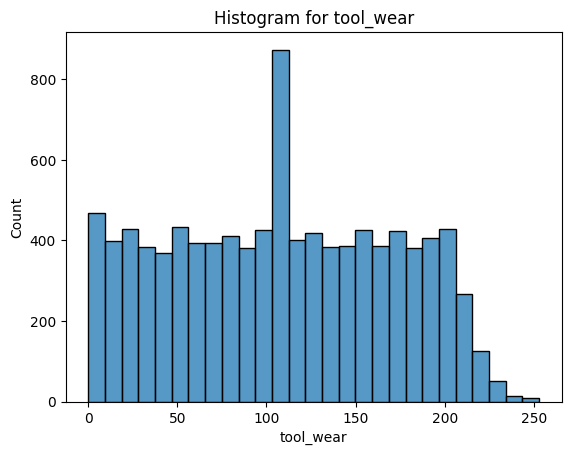

In [53]:
plott = Plotter(failure_data_df)
plott.histplot('tool_wear')
plt.show()

- The Upper limit of `Tool Wear` is 200 - 250 rpm

### M4) Task 2: Determine the failure rate in the process

You've been tasked with determining how many and the leading causes of failure are in the manufacturing process.


Determine and visualise how many failures have happened in the process, what percentage is this of the total? Check if the failures are being caused based on the quality of the product.

In [54]:
# Understand the different failure types 
failure_types = ['machine_failure', 'tool_wear_failure', 'head_dissapation_failure', 'power_failure','overstrain_failure','random_failure']

failure_sum_df = failure_data_df[failure_types].sum()
print(failure_sum_df) # TODO: needs a column heading

machine_failure_total = failure_sum_df[0]
sum_of_other_machine_failures = sum(failure_sum_df[1:])

# Check if the total of other machine failure types equals the machine_failure count
are_failures_equal = machine_failure_total == sum_of_other_machine_failures

# check if the other machine failure types equal the machine_failure count
print(f'Do the Total number of other failure types (RNF, PWF,..etc) equal the `machine_failure` total?: \n{are_failures_equal}')

if not are_failures_equal:
    print('''This result is `False`, indicating that the `machine_failure` flag can represent 
         multiple failure types for a single observation. For example, one observation can contain both 
         a random failure and a PWF failure.''')

machine_failure             268
tool_wear_failure            46
head_dissapation_failure    109
power_failure                33
overstrain_failure           85
random_failure               19
dtype: int64
Do the Total number of other failure types (RNF, PWF,..etc) equal the `machine_failure` total?: 
False
This result is `False`, indicating that the `machine_failure` flag can represent 
         multiple failure types for a single observation. For example, one observation can contain both 
         a random failure and a PWF failure.


/var/folders/5k/scs93vzn4cg5yycybmzlxrk00000gn/T/ipykernel_87210/2782959113.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  machine_failure_total = failure_sum_df[0]


In [55]:
# Create a general `failure` variable that is 1 if any type of failure is present
failure_data_df['failure'] = (
    (failure_data_df['machine_failure'] == 1) | 
    (failure_data_df['tool_wear_failure'] == 1) | 
    (failure_data_df['head_dissapation_failure'] == 1) | 
    (failure_data_df['power_failure'] == 1) | 
    (failure_data_df['overstrain_failure'] == 1) | 
    (failure_data_df['random_failure'] == 1)
).astype(int)

Number of Failures is defined as observation that failed for ANY failure type
Number of Failures: 286
Percentage Failure Rate: 2.8988445165213865


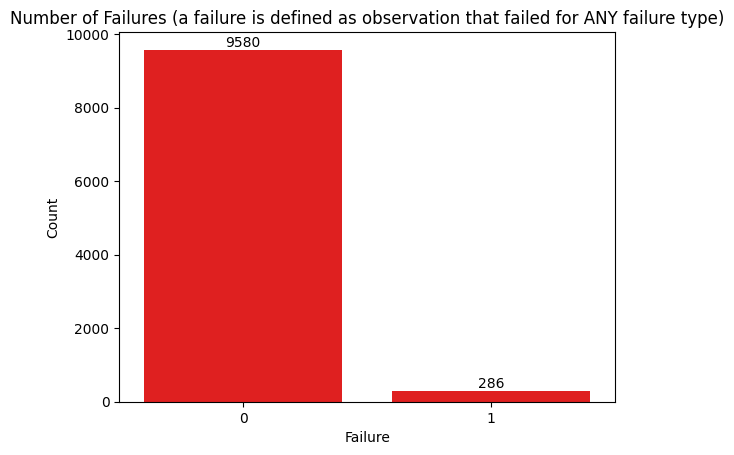

In [56]:
print('Number of Failures is defined as observation that failed for ANY failure type')
number_of_failures = failure_data_df['failure'].sum()
print(f"Number of Failures: {number_of_failures}")

percentage_failure_rate = (number_of_failures/ len(failure_data_df)) * 100
print(f"Percentage Failure Rate: {percentage_failure_rate}")

ax = sns.countplot(failure_data_df, x='failure', color='red')
# Add data labels to each bar
ax.bar_label(ax.containers[0])
plt.title('Number of Failures (a failure is defined as observation that failed for ANY failure type)')
plt.xlabel('Failure')
plt.ylabel('Count')
# Show the plot
plt.show()

- Across `10,000` runs the factory production failed `286` times



machine_failure             2.716400
tool_wear_failure           0.466248
head_dissapation_failure    1.104804
power_failure               0.334482
overstrain_failure          0.861545
random_failure              0.192581
dtype: float64


/var/folders/5k/scs93vzn4cg5yycybmzlxrk00000gn/T/ipykernel_87210/1655058360.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


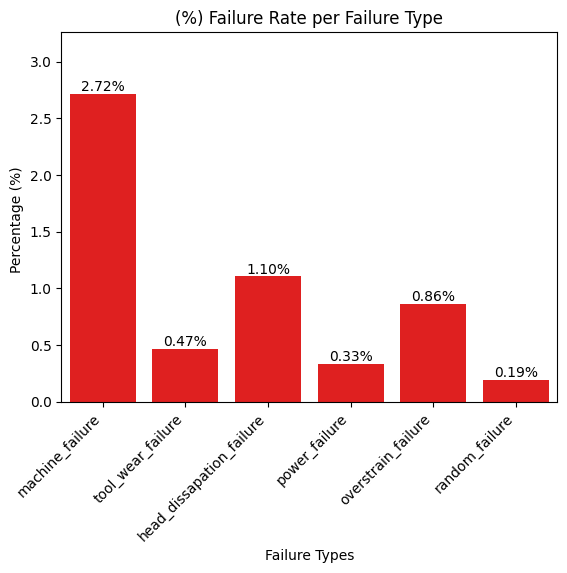

In [57]:
# # T2a) Calculate the % failure for each failure type
print('\n')
percentage_failures_df = failure_sum_df / len(failure_data_df) * 100 
print(percentage_failures_df) # TODO: needs a column heading

# Barplot of Percentage Failures
ax = sns.barplot(percentage_failures_df, color='red')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%') 
ax.set_title('(%) Failure Rate per Failure Type')
ax.set_ylabel('Percentage (%) ')
ax.set_ylim(0, percentage_failures_df.max() * 1.2) 
ax.set_xlabel('Failure Types')
# Rotate x-axis lables
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

- The `machine_failure` rate is `2.72%`, all other failures are considerably less common. Lets keep this rate in mind when discussing failure rate, to get an idea of scale.

Next lets look if there is a bias in out Data Set for the Product Type

/var/folders/5k/scs93vzn4cg5yycybmzlxrk00000gn/T/ipykernel_87210/2036274302.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(failure_data_df, x='Type', palette='Blues')


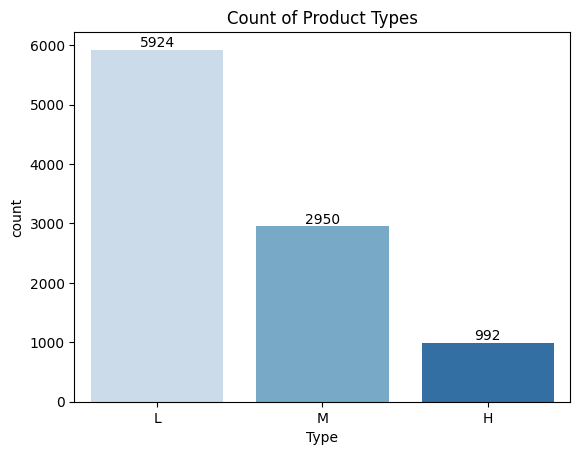

In [58]:
# Countplot: Product Types
ax = sns.countplot(failure_data_df, x='Type', palette='Blues')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f') # integer formatting
ax.set_title('Count of Product Types')
plt.show()

The data set is biased towards `L` Type of products. approximately 60% of the total production is for `L` type products.

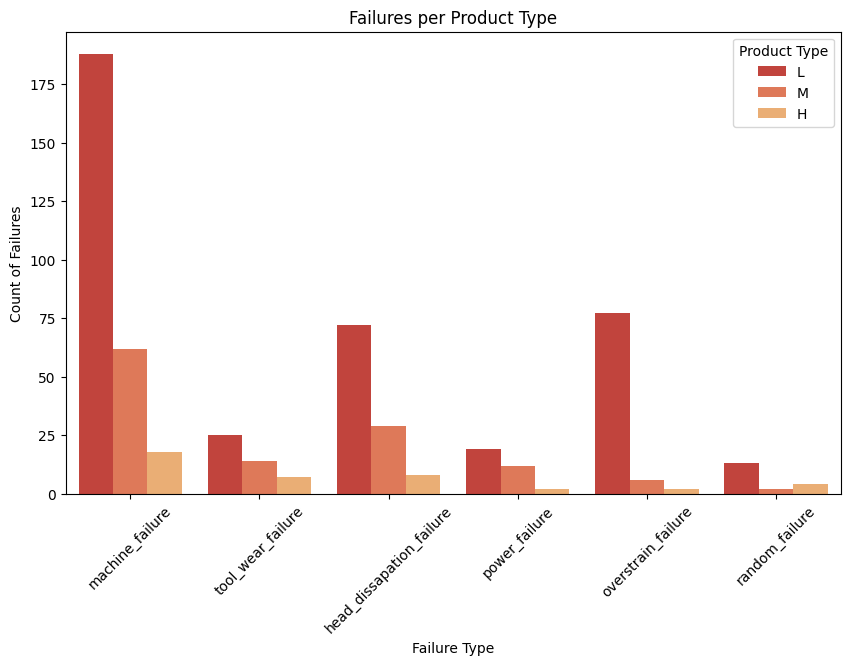

Leading cause of failure is in product type L, although this is biased as there are lot more observations for L product type than the rest.
machine_failure, overstrain_failure and head_dissapation_failures are the highest across the products


In [59]:
# Group by 'Type' and sum the failure columns
failures_per_type = failure_data_df.groupby('Type')[['machine_failure','tool_wear_failure', 'head_dissapation_failure', 'power_failure', 'overstrain_failure', 'random_failure']].sum()
# Reset Index
failures_per_type = failures_per_type.reset_index()
# Ensure the 'Type' column is categorical and ordered as 'L', 'M', 'H'
failures_per_type['Type'] = pd.Categorical(failures_per_type['Type'], categories=['L', 'M', 'H'], ordered=True)
# Reindex to ensure order
failures_per_type = failures_per_type.set_index('Type').loc[['L', 'M', 'H']]
# Convert the DataFrame back to a long format using melt
failures_per_type_melted = failures_per_type.reset_index().melt(id_vars='Type', var_name='Failure Type', value_name='Count')
# Define custom colors: different shades of red for 'L', 'M', 'H'
custom_palette = {
    'L': '#d73027',  # Dark red
    'M': '#f46d43',  # Medium red
    'H': '#fdae61'   # Light red
}
# Plot using seaborn's barplot with custom colors based on the product type (L, M, H)
plt.figure(figsize=(10, 6))
sns.barplot(x='Failure Type', y='Count', hue='Type', data=failures_per_type_melted, palette=custom_palette)
# Add labels and title
plt.title('Failures per Product Type')
plt.xlabel('Failure Type')
plt.ylabel('Count of Failures')
plt.legend(title='Product Type')
# Show the plot
plt.xticks(rotation=45)
plt.show()

print('Leading cause of failure is in product type L, although this is biased as there are lot more observations for L product type than the rest.')
print('machine_failure, overstrain_failure and head_dissapation_failures are the highest across the products')

### M4) Task 3: A Deeper Understanding of Failures 

For each different possible type of failure lets investigate if there is any correlation between any of the settings the machine was running at. 

For the Correlation Heatmap, lets drop columns that we do not need.

In [60]:
# Drop columns for correlation heat map
print(failure_data_df.head())
print(failure_data_df.columns)
dt = DataTransform(failure_data_df)
failure_data_df = dt.drop_column(['UDI', 'Type'])

    UDI Type  air_temperature  process_temperature  rotational_speed_actual  \
0  3416    L            301.4                310.4                     1579   
1  7130    L            300.6                310.0                     1635   
2  2320    M            299.2                308.8                     1700   
3  9601    M            298.9                310.0                     1561   
4   614    L            298.1                309.9                     1634   

   torque  tool_wear  machine_failure  tool_wear_failure  \
0    36.9      133.0                0                  0   
1    31.0      107.0                0                  0   
2    33.5      185.0                0                  0   
3    45.3       58.0                0                  0   
4    30.0       53.0                0                  0   

   head_dissapation_failure  power_failure  overstrain_failure  \
0                         0              0                   0   
1                         0     

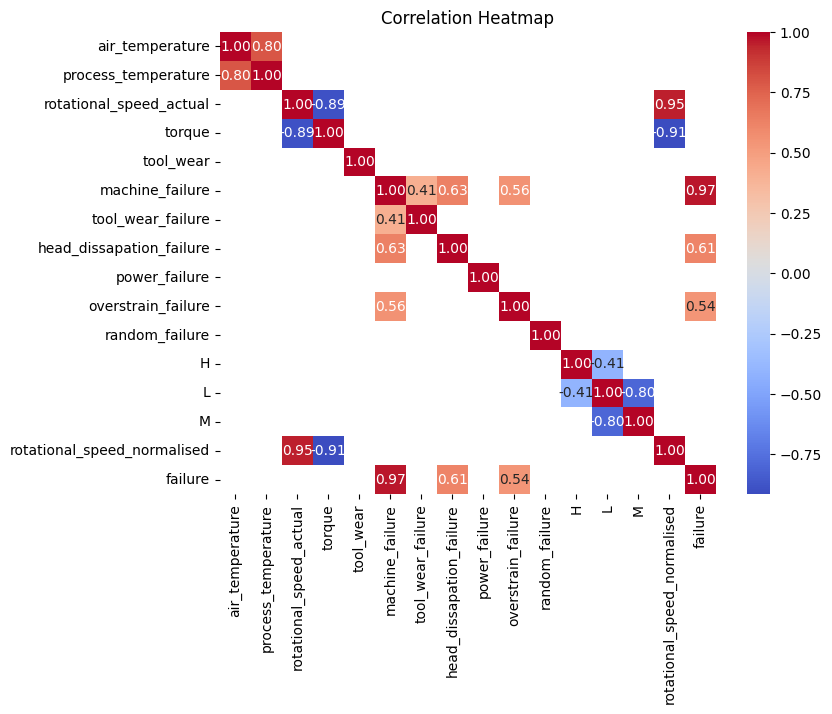

Machine failure is weakly correlated with OSF, HDF and TWF


In [62]:
# Correlation Heatmap with a threshold 0.4
plott = Plotter(failure_data_df)
plott.correlation_heatmap(threshold=0.40, figsize=(8,6))
plt.show()

print('Machine failure is weakly correlated with OSF, HDF and TWF')

Note that a threshold of `0.4` was used. This shows correlations greater that 40% only. 
- `rotational_speed` and 'torque' are highly correlated
- `air_temperature` and `process_temperature` are highly correlated

3b) Do the failures happen at certain torque ranges, processing temperatures or rpm?

In [66]:
# Save a copy of the df 
failure_data_df_copy = failure_data_df.copy()

Lets look at `machine_failure` vs `predictor variables` using the `Logistic Regression Model`
- See the appendix for the reasoning behing using a logitic regression model over OLS

Optimization terminated successfully.
         Current function value: 0.090565
         Iterations 10


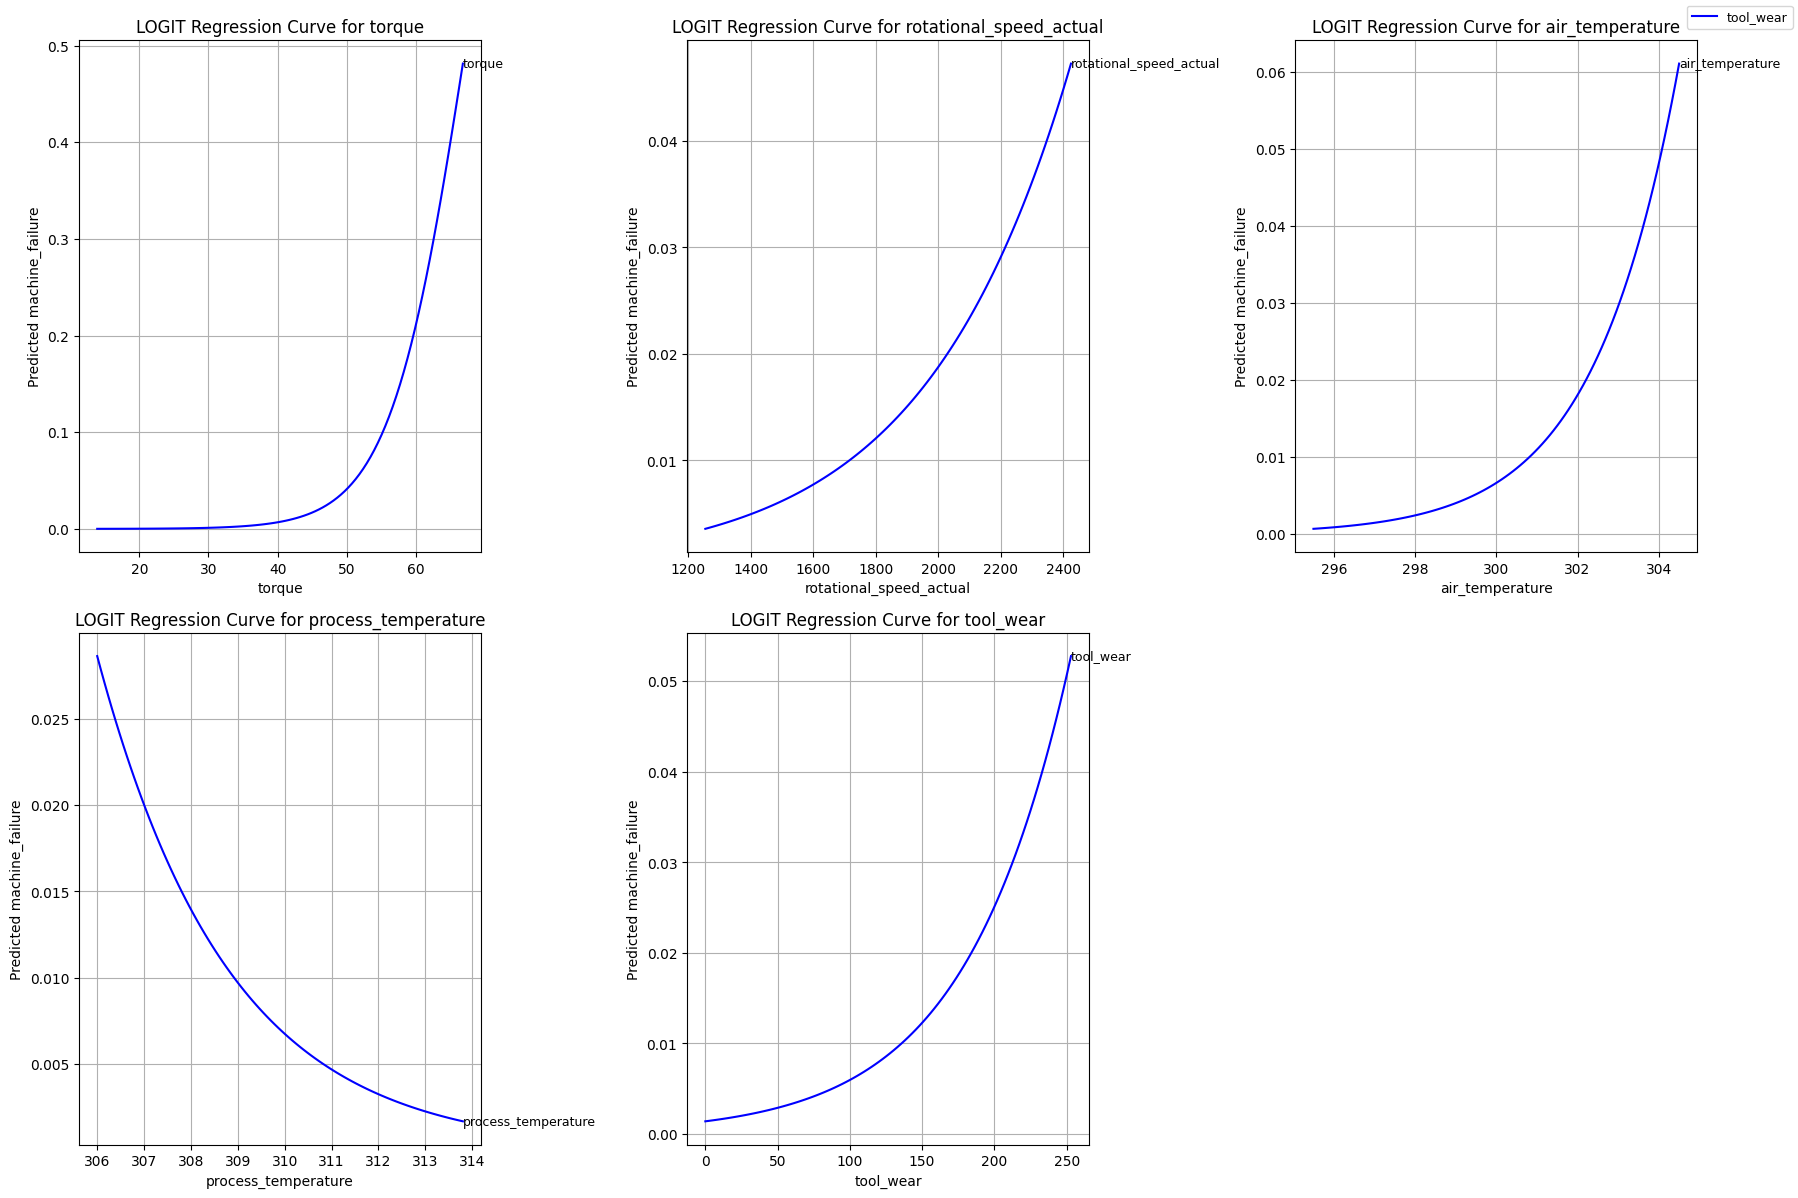

{'torque': {'first_derivative_min': None, 'second_derivative_min': None},
 'rotational_speed_actual': {'first_derivative_min': None,
  'second_derivative_min': None},
 'air_temperature': {'first_derivative_min': None,
  'second_derivative_min': None},
 'process_temperature': {'first_derivative_min': None,
  'second_derivative_min': None},
 'tool_wear': {'first_derivative_min': None, 'second_derivative_min': None}}

In [67]:
# 1) Logistic Regression: Model Curves 
model = Models(failure_data_df)
predictor_vars = ['torque', 'rotational_speed_actual', 'air_temperature', 'process_temperature', 'tool_wear']
model.plot_model_curves(predictor_vars, model='logit', ncols=3, standardize=False)

The logistic curve helps to see where the `machine_failure` rate increases, visually this is where the curve becomes steep. 
`torqe` shows thes the largest impact on the probility of the machine failures, as it's axis (data) go up to nearly 50% i.e. there are torque vales (above 60 rpm) where the `machine_failure` is almost 50%
For example, for the predictor variable `torque` this is around `50 rpm`

Next we will plot the first and second derivative of above curves, to see the behaviour of the data in greater detail

Optimization terminated successfully.
         Current function value: 0.090565
         Iterations 10


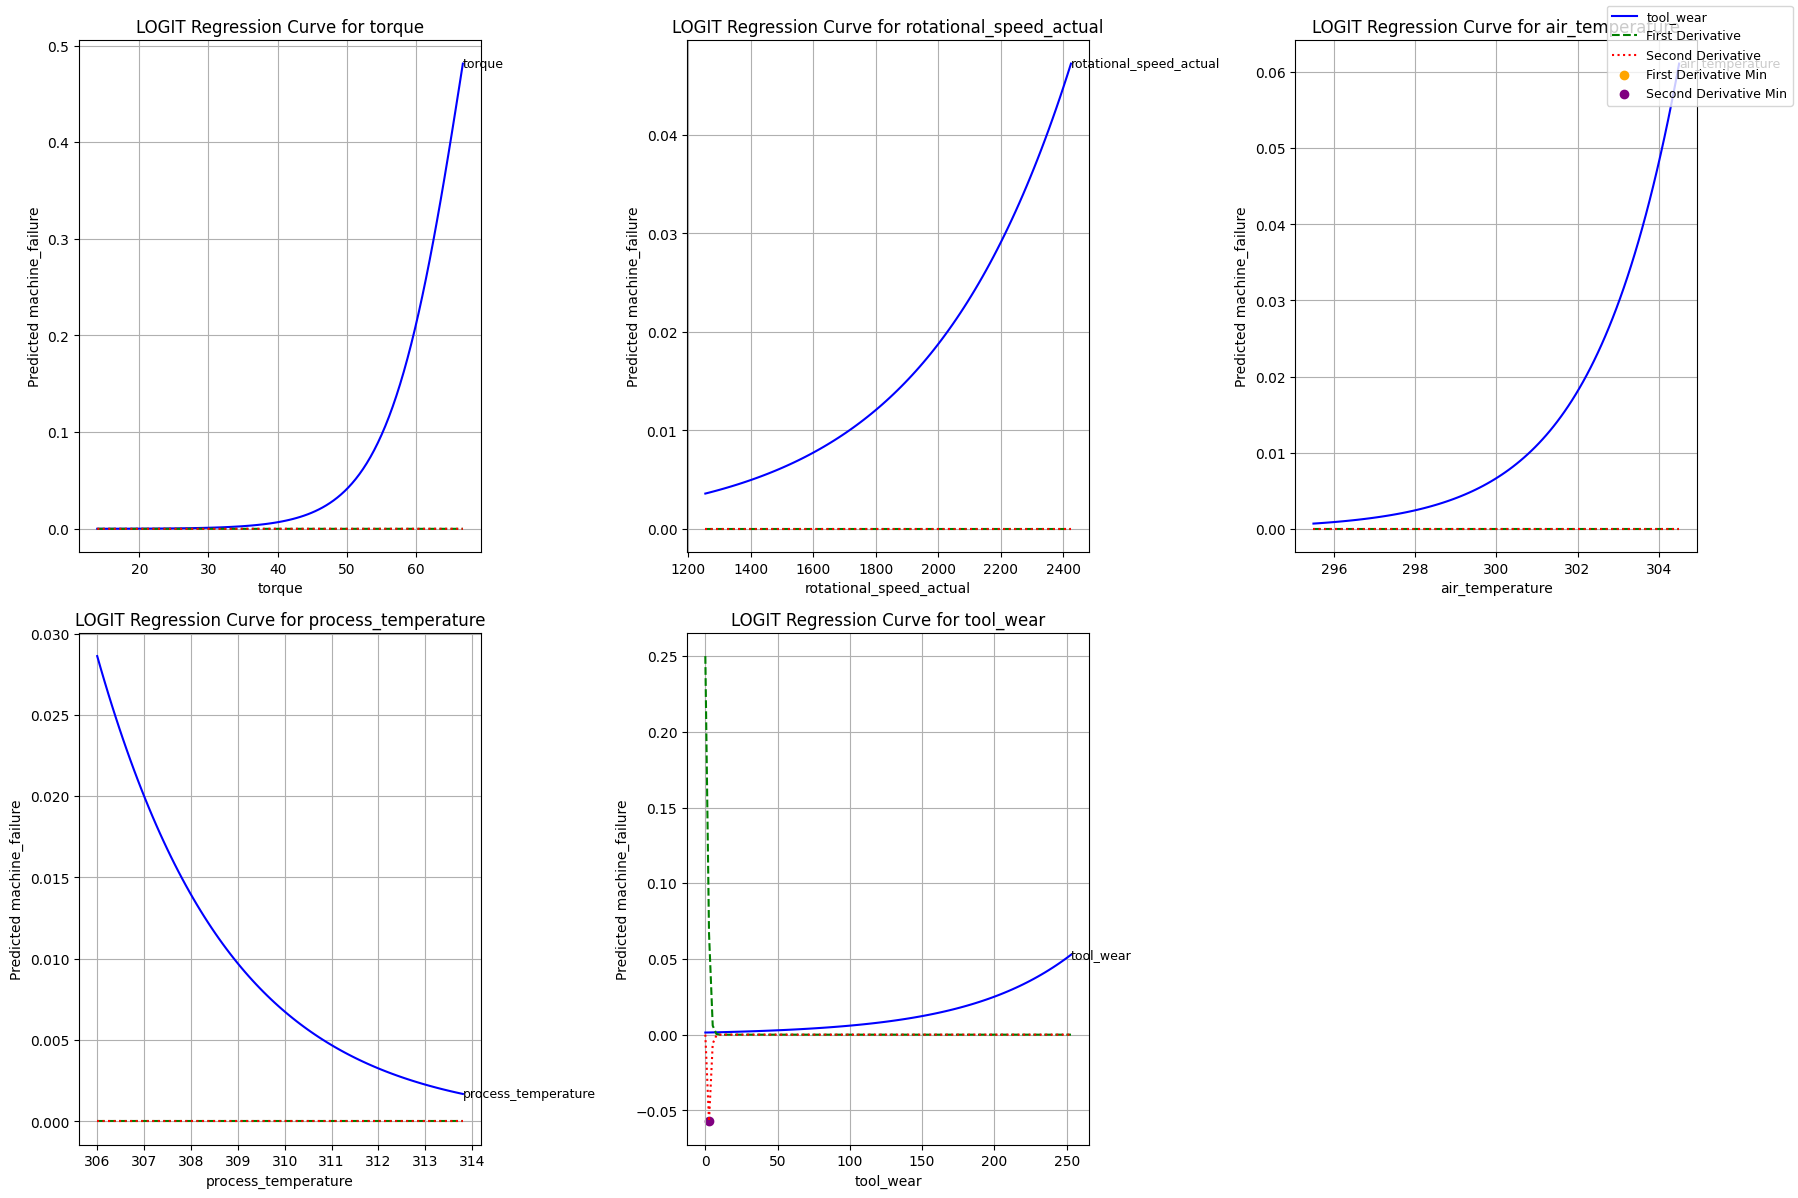

{'torque': {'first_derivative_min': (None, None),
  'second_derivative_min': (None, None)},
 'rotational_speed_actual': {'first_derivative_min': (None, None),
  'second_derivative_min': (None, None)},
 'air_temperature': {'first_derivative_min': (None, None),
  'second_derivative_min': (None, None)},
 'process_temperature': {'first_derivative_min': (None, None),
  'second_derivative_min': (None, None)},
 'tool_wear': {'first_derivative_min': (None, None),
  'second_derivative_min': (2.5555555555555554, -0.05722692613060092)}}

In [68]:
# 2) Plot of Actuals with Derivatives - Shows that the fist and second derivative don't tell us much as the values are not interpretable with Actuals & logistic regression.
model.plot_model_curves(predictor_vars, model='logit', ncols=3, standardize=False, plot_derivatives=True, local_minima=True)

As you can see the first and second derivative is not helpful in understanding the behaviour of `machine_failures` against our predictor variables. 
The curves are flat because we are using actual values which intern do not work very well with the logistic model.

To solve for this we will standardise the data and then plot the derivative curves.

Optimization terminated successfully.
         Current function value: 0.090565
         Iterations 9


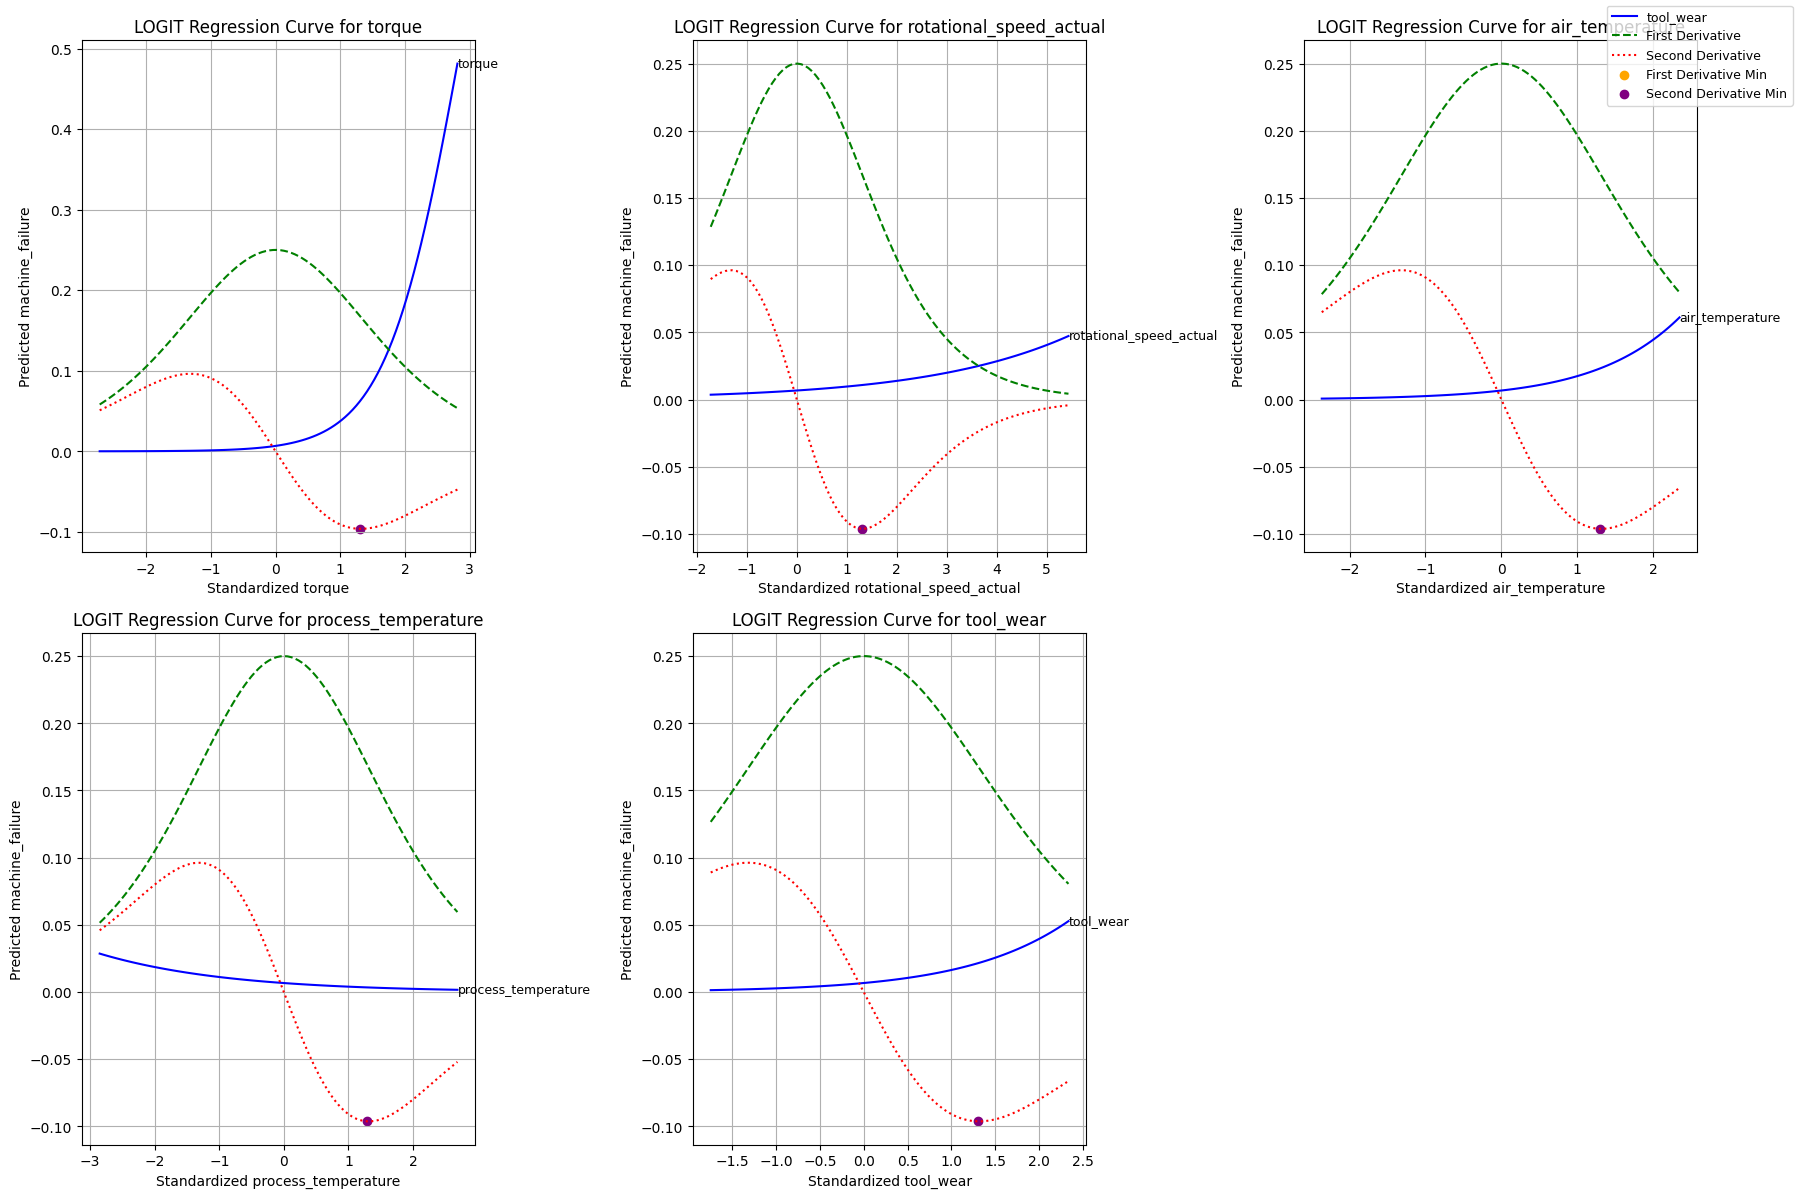

{'torque': {'first_derivative_min': (None, None), 'second_derivative_min': (1.302532048803255, -0.09621497698616391)}, 'rotational_speed_actual': {'first_derivative_min': (None, None), 'second_derivative_min': (1.3150438456951041, -0.09622486847047655)}, 'air_temperature': {'first_derivative_min': (None, None), 'second_derivative_min': (1.2994355529261714, -0.09621017351230728)}, 'process_temperature': {'first_derivative_min': (None, None), 'second_derivative_min': (1.2896496029825735, -0.0961887904634136)}, 'tool_wear': {'first_derivative_min': (None, None), 'second_derivative_min': (1.3044680174931413, -0.09621750346930949)}}


In [69]:
# 3) Standardised Vars with First and Second derivative
dict_minima_coordinates = model.plot_model_curves(predictor_vars, model='logit', ncols=3, standardize=True, plot_derivatives=True, local_minima=True)

print(dict_minima_coordinates)

Now the probability of `machine_failure`can be seen more clearly after standardising our data. 

Focusing on the `machine_failure` vs `torque` plot; the lower `torque` values (to the left), the blue line remains relatively flat indicating low probability of machine failure. 
As `torque` increases to a standardised value of 1, the probability of failure sharply increases. 
The second derivative tells us how the curvature changes. The red dot (local minimum of the second derivative) marks the point where the curves' concavity changes, indicating a shift in the failure risk trend. After this point the probability of failure increases more sharply as `torque` rises. 

Next we will use the red dot (local minimum of the second derivative) to come up with a theoretical operating threshold for our predictor variables.

In [70]:
# Descale (or Inverse the Scaling) of the Local Minima (red dot)
print('Results \n:')
dict_descaled_minima_coordinates = model.inverse_scale_minima(dict_minima_coordinates)
print(dict_descaled_minima_coordinates)

Results 
:
{'torque': {'first_derivative_min': (None, None), 'second_derivative_min': (52.372727272727275, -0.09621497698616391)}, 'rotational_speed_actual': {'first_derivative_min': (None, None), 'second_derivative_min': (1750.9393939393938, -0.09622486847047655)}, 'air_temperature': {'first_derivative_min': (None, None), 'second_derivative_min': (302.5, -0.09621017351230728)}, 'process_temperature': {'first_derivative_min': (None, None), 'second_derivative_min': (311.830303030303, -0.0961887904634136)}, 'tool_wear': {'first_derivative_min': (None, None), 'second_derivative_min': (189.11111111111111, -0.09621750346930949)}}


Theoretical Strategy: 
{'torque': [52], 'rotational_speed_actual': [1751], 'air_temperature': [302], 'process_temperature': [312], 'tool_wear': [189]}
Optimization terminated successfully.
         Current function value: 0.090565
         Iterations 10


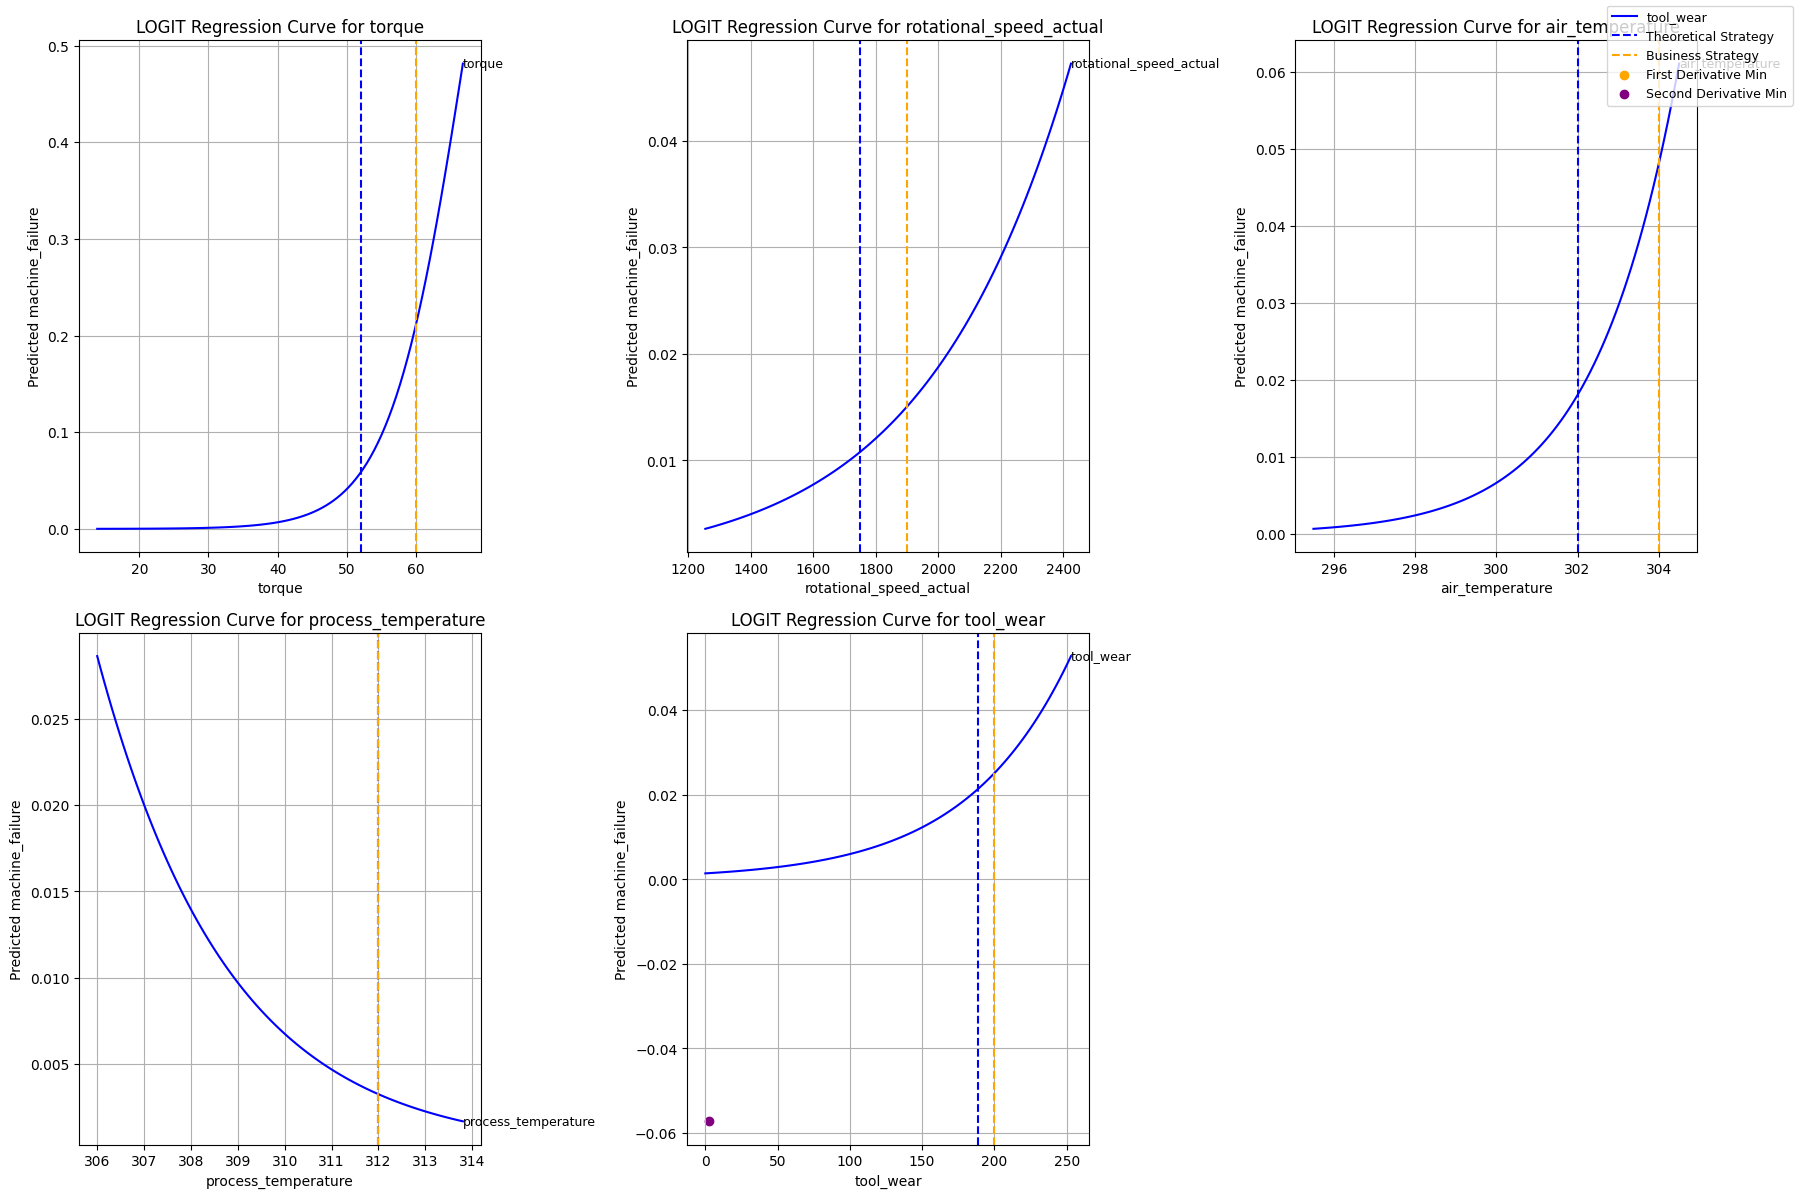

{'torque': {'first_derivative_min': (None, None),
  'second_derivative_min': (None, None)},
 'rotational_speed_actual': {'first_derivative_min': (None, None),
  'second_derivative_min': (None, None)},
 'air_temperature': {'first_derivative_min': (None, None),
  'second_derivative_min': (None, None)},
 'process_temperature': {'first_derivative_min': (None, None),
  'second_derivative_min': (None, None)},
 'tool_wear': {'first_derivative_min': (None, None),
  'second_derivative_min': (2.5555555555555554, -0.05722692613060092)}}

In [71]:
# Extract only the rounded x-values of the second derivatives
theoretical_strategy = model.extract_x_value_of_second_derivative(dict_descaled_minima_coordinates)
# We will call this our Theoretical Strategy 
print(f'Theoretical Strategy: \n{theoretical_strategy}')

# Business strategy based on speculation
business_strategy = {
    'torque': [60],
    'rotational_speed_actual': [1900],
    'air_temperature': [304],  # Vertical lines at 15 and 25
    'process_temperature': [312],  # Vertical lines at 70 and 80
    'tool_wear': [200]
}

# 4) Plot of Theoretical and Business Strategy on Actuals
model = Models(failure_data_df_copy)
model.plot_model_curves(predictor_vars, model='logit', ncols=3, standardize=False, plot_derivatives=False, local_minima=True, theoretical_strategy=theoretical_strategy, 
                                        business_strategy=business_strategy)

The above plot shows our `Theoretical Startegy` and `Business Statregy` by the use of the blue and yellow dotted lines, respectfully.
The `Business Strategy` was selected from speculation, the `Theoretical Strategy`, in the context of our data represents the ideal-scenraio, not necessarily the best for the business.
As we can see from the graph, this strategy cuts a lot of our data i.e. production output. Next we will show the impact of such Thresholds on key metrics for the business. 

In [72]:
# Generate The impact of the strategy
dict_impact_of_theoretical_strategy = model.impact_of_strategy(theoretical_strategy)
result_theoretical_strategy = model.present_results(result_dict=dict_impact_of_theoretical_strategy)

dict_impact_of_business_strategy = model.impact_of_strategy(business_strategy)
result_business_approach = model.present_results(result_dict=dict_impact_of_business_strategy)

Original Failure Rate: 2.71639975674032
Total Data Points: 9866
Best Order of Applying Filters: ('torque', 'rotational_speed_actual', 'air_temperature', 'process_temperature', 'tool_wear')
Original Failure Rate
Lowest Failure Rate After Applying Best Order: 0.29%
Production Loss: 4339
Improvement Percentage: 89.34%
Original Failure Rate: 2.71639975674032
Total Data Points: 9866
Best Order of Applying Filters: ('torque', 'rotational_speed_actual', 'air_temperature', 'process_temperature', 'tool_wear')
Original Failure Rate
Lowest Failure Rate After Applying Best Order: 1.36%
Production Loss: 2013
Improvement Percentage: 49.84%


In [73]:
print('\n')
print(f'Results of Theoretical Strategy: \n {result_theoretical_strategy}')
print(f'Results of Business Strategy \n {result_business_approach}')



Results of Theoretical Strategy: 
 
        Model Results:
        ------------------------------
        Best Order of Applying Filters:
        - torque -> rotational_speed_actual -> air_temperature -> process_temperature -> tool_wear
        
        Original Failure Rate: 2.72%
        Failure Rate After applying Strategy: 0.29%
        
        Production Loss: 4339 units
        Relative Improvement in Failure Rate: 89.34%
        
Results of Business Strategy 
 
        Model Results:
        ------------------------------
        Best Order of Applying Filters:
        - torque -> rotational_speed_actual -> air_temperature -> process_temperature -> tool_wear
        
        Original Failure Rate: 2.72%
        Failure Rate After applying Strategy: 1.36%
        
        Production Loss: 2013 units
        Relative Improvement in Failure Rate: 49.84%
        


The results show the importance of having a balance approach between the 'Theoretical Strategy' and what might be best for the business. 
While impact of the `Theoretical Strategy` improves the orginal failure rate of `2.72%` to `0.29%` it also means a production loss of approximately 43% (4339 units). 

The `Business Strategy` shows an example of how the business

Note that the `Relative Improvement in Failure Rate` is a percentage improvement relative to two percentages, this is detailed in the appendix.

#### Evaluation 
- Create thresholds to cut the machine off, when it hits certain values for certain variables. My recommendation to the firm would be to choose thresholds greater than those in the `Theoretical Startegy`. Perhaps they can  use this threshold as a benchmark to create awarness that failure rates are likely to accelerate from this point onwards, in practice this could be a `Yellow Light` on the factory floor indicating to managers that the machine is now operating at rate where machine failures will accelerate. 
- I suggest that the cutt-off thresholds to be based on the `Theoretical Strategy` and input from the business stakeholders. Can the business provide the cost due to machine failure? for example lets say that currently the machine failure rate is 3% and this equates to a £300,000 loss due to repairs and production stoppage, then for every 1% the machine failure rate is reduced the firm saves £100,000 and if the revenue lost due to a reduction in production is less than £100,000 then the threshold is worth implementing. 

- The variable `torque` shows the most potential in reducing the probability of failure rates as it's affect on the machine failure has the largest range, going up to nearly a probability of a 50% machine failure rate. This is a varible that may be worthwhile having a threshold of it's own that cuts production. 

#### Future improvements:
Interactive plot that shows the impact of a set threshold on the KPI's of the business 
- Widgets that allow the use to slide the threshold which simultaneosly updates the core KPI's
- KPIs suchas; Production Output (Units), Revenue (profit - loss) and Failure rate. Profit can also be assumed by giving a profit from each product e.g. L = £1, M = £2 ...etc
- ML approach to predicting `machine_failure`

# Appendix

### Appendix - OLS Model, inpreparation for VIFS 

In [74]:
# TODO: Appendix 
# ## fit a linear model to predict machine_failure from the continous independant variables 
# print('OLS model: using rotational_speed without normalisation')
# ols_1 = smf.ols("machine_failure ~ air_temperature + process_temperature + rotational_speed_original + torque + tool_wear", failure_data_step_5_collinearity).fit()
# print(ols_1.summary())

In [75]:
# TODO: Appendix 
# print('OLS model: using NORMALISED rotational speed')
# ols_2 = smf.ols('machine_failure ~ air_temperature + process_temperature + rotational_speed_normalised + torque + tool_wear', failure_data_step_5_collinearity).fit()
# print(ols_2.summary())


- Use the `r^2` term from the OLS model using `rotational_speed_normalised`
- Note that the OLS model that uses `rotational_speed_normalised` gives a statitically significant p-value vs the `rotational_speed_orginal`which is statistically insignificant. This is expected as OLS relies on the assumption that the data follows a normal distribution.
- Further validating that `rotational_speed` was skewed. 


### VIFS 

*Variation Inflation Factor*, or VIF. This method is more powerful than the aforementioned as we fit a linear regression model on one of our independent variables against all the other exogenous variables. Mathematically, for one variable `X_1`:
$$
\hat{X_1} = \beta_0 + \beta_1(X_2) + \beta_2(X_3) + ...
$$

Subsequently, we'd work out the VIF, which uses the `R^2` obtained from the model:
$$
\text{VIF} \equiv \frac{1}{1-R^2_1}
$$

### Appendix - Skewness

0    0.000000
1    0.248875
dtype: float64


<Axes: >

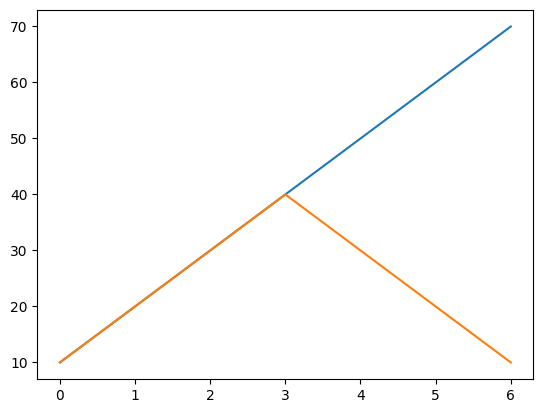

In [76]:
# TODO: put this in the appendix 
# interpreting the skew() value

data = [(10, 20, 30, 40, 50, 60, 70), 
        (10, 20, 30, 40, 30, 20, 10) ]
df = pd.DataFrame(data)
df
skew_value = df.skew(axis=1)
print(skew_value)

df.iloc[0].plot()
df.iloc[1].plot()

- In the first row of the data the values are `(10, 20, 30, 40, 50, 60, 70)`, plotted by the blue line. This is a perfectly symmetrical data set when considered with respect to the mean. Even though the values are increasing, they are evenly spaced, and the distribution around the mean is symmetric.SystemError

TODO: put the underlying skew calculation (theory) in the appendix.

#### Appendix - OLS vs Logit 

In [78]:
# Preprocess Data 
print('##############################################################################')
print('Step 0: Load the Data')
load_data = LoadData('failure_data.csv')  # Instantiate the class with your file name
failure_data_df = load_data.df  # Access the loaded DataFrame
print('##############################################################################')
print('Step 1: Initial Data Cleaning')
dt = DataTransform(failure_data_df)
failure_data_df = dt.drop_column(['Unnamed: 0', 'Product ID'])

dt = DataTransform(failure_data_df)
type_dummy_df = dt.create_dummies_from_column('Type')
failure_data_df = dt.concat_dataframes(type_dummy_df)

info = DataFrameInfo(failure_data_df)
print(f"\nColumns After concatination: \n{info.column_names()}")
print('##############################################################################')
print('Step 2: Impute missing values')
imputation_dict = {
    'Air temperature [K]': 'median',
    'Process temperature [K]': 'mean',
    'Tool wear [min]': 'median'
}
dt = DataTransform(failure_data_df)
failure_data_df = dt.impute_missing_values(imputation_dict)
info = DataFrameInfo(failure_data_df)
print(f"\nCheck\nPercentage of Null Values for each column after imputation: \n{info.percentage_of_null()}")
print('##############################################################################')
print('Step 3: Treating Skewness')
dt = DataTransform(failure_data_df)
info = DataFrameInfo(failure_data_df)
print(f"\nSkew Test Before treatement: {info.skew_test('Rotational speed [rpm]')}")
failure_data_df = dt.treat_skewness(column_name='Rotational speed [rpm]', normalied_column_name='rotational_speed_normalised', method='yeojohnson') # 
info = DataFrameInfo(failure_data_df)
print(f"\nSkew Test After treatement: {info.skew_test('rotational_speed_normalised')}")
print('##############################################################################')
print('Step 4: Removing Outliers')
dt = DataTransform(failure_data_df)

info = DataFrameInfo(failure_data_df)
outlier_columns = ['rotational_speed_normalised', 'Torque [Nm]', 'Process temperature [K]']
print(f"\nBefore Removing outliers: {info.describe_statistics(outlier_columns)}")

failure_data_df, _, _ = dt.remove_outliers_with_optimiser(outlier_columns, key_ID='UDI', method='IQR', suppress_output=True)

info = DataFrameInfo(failure_data_df)
print(f"\nAfter Removing outliers: {info.describe_statistics(outlier_columns)}")
print('##############################################################################')
dt = DataTransform(failure_data_df)
machine_failure_col_mapping = {
    'Machine failure': 'machine_failure',
    'Air temperature [K]': 'air_temperature',
    'Process temperature [K]': 'process_temperature',
    'Rotational speed [rpm]': 'rotational_speed_actual',
    'Torque [Nm]': 'torque',
    'Tool wear [min]': 'tool_wear',
    'TWF': 'tool_wear_failure',
    'HDF': 'head_dissapation_failure',
    'PWF': 'power_failure',
    'OSF': 'overstrain_failure',
    'RNF': 'random_failure'
}
# rename df 
failure_data_df = dt.rename_colunms(machine_failure_col_mapping)
print('##############################################################################')

##############################################################################
Step 0: Load the Data
File found: /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv
DataFrame loaded successfully from /Users/manishkhurmi/Desktop/EDA_project/failure_data.csv.
##############################################################################
Step 1: Initial Data Cleaning
Column List: 
 Index(['Unnamed: 0', 'UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

Column List After dropping df
: Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

Columns After concatination: 
Index(['UDI', 'Type', 'Air temperature [K]', 'Process temperature [K

In [79]:
# OLS model 
model = Models(failure_data_df)
predictor_vars = ['torque', 'rotational_speed_actual', 'air_temperature', 'process_temperature', 'tool_wear']
ols_model_machine_failure = model.ols(formula = "machine_failure ~ air_temperature + process_temperature + rotational_speed_actual + torque + tool_wear", model_summary=1)

                    Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.071     
Dependent Variable:   machine_failure   AIC:                 -8568.6163
Date:                 2024-10-18 15:01  BIC:                 -8525.4352
No. Observations:     9866              Log-Likelihood:      4290.3    
Df Model:             5                 F-statistic:         151.9     
Df Residuals:         9860              Prob (F-statistic):  7.12e-156 
R-squared:            0.072             Scale:               0.024551  
-----------------------------------------------------------------------
                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -1.4466   0.3534 -4.0931 0.0000 -2.1393 -0.7538
air_temperature          0.0117   0.0014  8.5507 0.0000  0.0090  0.0144
process_temperature     -0.0086   0.0019 -4.6257 0.0000 -0.0122 -0.0049
rotational_s

In [80]:
# LOGIT Model 
model = Models(failure_data_df)
predictor_vars = ['torque', 'rotational_speed_actual', 'air_temperature', 'process_temperature', 'tool_wear']
# Prove that LOGIT model is better than OLS based on OLS's r-squared alone and the benefit that logistiric regression provides when variables are binary (1,0).
logit_model_machine_failure = model.logit(formula = "machine_failure ~ air_temperature + process_temperature + rotational_speed_actual + torque + tool_wear", model_summary=1)
print('R squared of logit model is shows a better fit than that of OLS.') # TODO: explain this better

Optimization terminated successfully.
         Current function value: 0.090565
         Iterations 10
                              Results: Logit
Model:                  Logit              Method:             MLE        
Dependent Variable:     machine_failure    Pseudo R-squared:   0.274      
Date:                   2024-10-18 15:01   AIC:                1799.0272  
No. Observations:       9866               BIC:                1842.2083  
Df Model:               5                  Log-Likelihood:     -893.51    
Df Residuals:           9860               LL-Null:            -1230.7    
Converged:              1.0000             LLR p-value:        1.7094e-143
No. Iterations:         10.0000            Scale:              1.0000     
--------------------------------------------------------------------------
                         Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------------
Intercept               -55

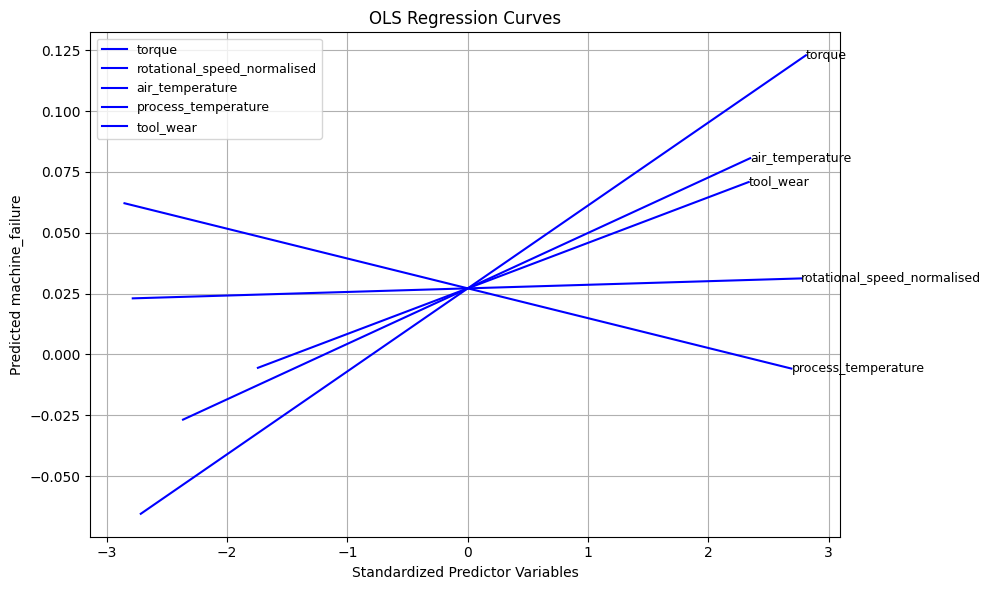

Optimization terminated successfully.
         Current function value: 0.090337
         Iterations 9


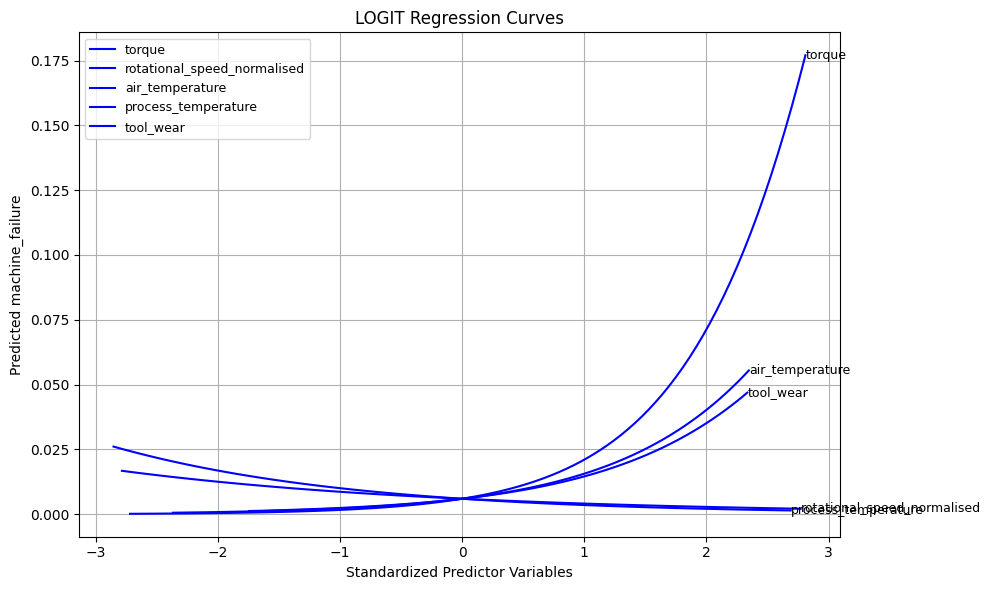

{'torque': {'first_derivative_min': None, 'second_derivative_min': None},
 'rotational_speed_normalised': {'first_derivative_min': None,
  'second_derivative_min': None},
 'air_temperature': {'first_derivative_min': None,
  'second_derivative_min': None},
 'process_temperature': {'first_derivative_min': None,
  'second_derivative_min': None},
 'tool_wear': {'first_derivative_min': None, 'second_derivative_min': None}}

In [82]:
# Visualising OLS & Logit Model
# Initialize the Models class
model = Models(failure_data_df)

# Define the continous predictor variables
predictor_vars = ['torque', 'rotational_speed_normalised', 'air_temperature', 'process_temperature', 'tool_wear']

# Plot OLS regression curves for each predictor variable in individual plots
model.plot_model_curves(predictor_vars, model='ols', combine_plots=1, standardize=True)

# compare with the Logit Model
# Plot Logit regression curves for each predictor variable in a combined plot
model.plot_model_curves(predictor_vars, model='logit', combine_plots=1, standardize=True)